In [2]:
import os
import tensorflow as tf

TF_ENABLE_ONEDNN_OPTS=1
os.environ["OMP_NUM_THREADS"]= "4"
os.environ["TF_NUM_INTRAOP_THREADS"]="4"
os.environ["TF_NUM_INTEROP_THREADS"]="2"

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)

# Reading shp files

In [6]:
import geopandas as gpd

shapefile_path = "Rooftop dataset/Annotations_Marhara_shp/RCC.shp"
gdf = gpd.read_file(shapefile_path)

print(gdf.head())
print(gdf.crs)

   OBJECTID  Category  GlobalID  Uniq_Id State_Code District_C Tehsil_Cod  \
0         2  Building       0.0      2.0         09        141       0744   
1         3  Building       0.0      3.0         09        141       0744   
2         5  Building       0.0      5.0         09        141       0744   
3         6  Building       0.0      6.0         09        141       0744   
4         7  Building       0.0      7.0         09        141       0744   

  Block_Code Village_Co    Area_Sqm  SHAPE_Leng  SHAPE_Area Remarks  \
0       0744     120372   51.456102   51.456102   51.456102    None   
1       0744     120372   59.603898   59.603898   59.603898    None   
2       0744     120372  268.626724  268.626724  268.626724    None   
3       0744     120372   50.238149   50.238149   50.238149    None   
4       0744     120372  120.684949  120.684949  120.684949    None   

         Adl_Info              Village_Na Water_type Roof_type  \
0  Potential Area  Amanullapur Urf Mahara   

In [20]:
import rasterio
from rasterio.features import rasterize
import numpy as np
from shapely.geometry import shape

image_path = "/home/user/Rooftop dataset/Marhara.tif"
with rasterio.open(image_path) as src:
    meta = src.meta.copy()

mask = np.zeros((meta["height"], meta["width"]), dtype=np.uint8)
shapes = [(geom, 1) for geom in gdf.geometry]

mask = rasterize(shapes, out_shape=(meta["height"], meta["width"]), transform = src.transform)

mask_path = "/home/user/Rooftop dataset/Mask.tif"
with rasterio.open(mask_path, "w", **meta) as dst:
    dst.write(mask, 1)

In [66]:
# mask = np.load("/home/user/Rooftop dataset/MarharaMask.tif")
# print("original mask values:", np.unique(mask))

import numpy as np
import cv2  # or any other library you are using to handle images

# Load your mask
mask = cv2.imread('/home/user/Rooftop dataset/MarharaMask.tif', cv2.IMREAD_GRAYSCALE)

# Get unique values in the mask
unique_classes = np.unique(mask)
print("Unique classes in the mask:", unique_classes)

Unique classes in the mask: [  0 255]


In [48]:
mask[mask == 255] = 2


In [59]:
print("loaded mask: ", np.unique(mask))

loaded mask:  [  0 255]


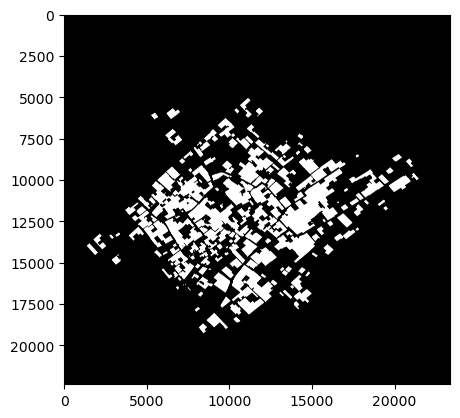

In [62]:
import matplotlib.pyplot as plt
plt.imshow(mask, cmap = "gray")
plt.show()

In [42]:
import cv2
import numpy as np
import os

# Adjust paths
image_path = "/home/user/Rooftop dataset/Marhara.tif"
mask_path = "/home/user/Rooftop dataset/MarharaMask.tif"

# 1. Read the image and mask with OpenCV
image = cv2.imread(image_path)                # May fail with large or multi-band TIF
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

# 2. Check if reading was successful
if image is None:
    print("Image not read. Possibly a path or format issue.")
else:
    print("Image shape:", image.shape)

if mask is None:
    print("Mask not read. Possibly a path or format issue.")
else:
    print("Mask shape:", mask.shape)
    print("Mask unique values:", np.unique(mask))

# 3. Quick check of pixel values
if mask is not None:
    # For instance, visualize 200x200 top-left region
    sub_region = mask[0:200, 0:200]
    print("Sub-region unique values:", np.unique(sub_region))

Image shape: (22361, 23351, 3)
Mask shape: (22361, 23351)
Mask unique values: [  0 255]
Sub-region unique values: [0]


In [1]:
import numpy as np
from pathlib import Path
import cv2
import random

def generate_patches(image, mask, patch_size=512, overlap_percent=30, 
                    min_content_percent=10, include_empty=True, empty_patch_ratio=0.1):

    if image.shape[:2] != mask.shape[:2]:
        raise ValueError("Image and mask dimensions must match")
    
    h, w = image.shape[:2]
    stride = int(patch_size * (1 - overlap_percent/100))
    
    content_patches = []
    empty_patches = []
    
    for y in range(0, h-patch_size+1, stride):
        for x in range(0, w-patch_size+1, stride):
            # Extract patches
            img_patch = image[y:y+patch_size, x:x+patch_size].copy()
            mask_patch = mask[y:y+patch_size, x:x+patch_size].copy()
            
            # Calculate foreground content
            foreground_pixels = np.sum(mask_patch > 0)
            content_percent = (foreground_pixels / (patch_size * patch_size)) * 100
            
            if content_percent >= min_content_percent:
                content_patches.append((img_patch, mask_patch, (x, y)))
            elif content_percent < 1:  # Almost empty patches
                empty_patches.append((img_patch, mask_patch, (x, y)))
    
    # Calculate how many empty patches to include
    if include_empty and empty_patches:
        num_empty_to_include = int(len(content_patches) * empty_patch_ratio)
        selected_empty = random.sample(empty_patches, min(num_empty_to_include, len(empty_patches)))
        return content_patches + selected_empty
    
    return content_patches

def save_patches(patches, output_dir, image_prefix="img", mask_prefix="mask"):
    """
    Save generated patches to disk
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for idx, (img_patch, mask_patch, (x, y)) in enumerate(patches):
        # Create filename with position information
        filename = f"{idx:04d}_x{x}_y{y}"
        
        # Save image patch
        img_path = output_dir / f"{image_prefix}_{filename}.png"
        cv2.imwrite(str(img_path), img_patch)
        
        # Save mask patch
        mask_path = output_dir / f"{mask_prefix}_{filename}.png"
        cv2.imwrite(str(mask_path), mask_patch)

def analyze_patch_distribution(patches):
    """
    Analyze the content distribution in generated patches
    """
    content_percentages = []
    for _, mask_patch, _ in patches:
        content = np.sum(mask_patch > 0) / mask_patch.size * 100
        content_percentages.append(content)
    
    return {
        'total_patches': len(patches),
        'avg_content': np.mean(content_percentages),
        'empty_patches': sum(1 for x in content_percentages if x < 1),
        'distribution': {
            'empty (0-1%)': sum(1 for x in content_percentages if x < 1),
            'low (1-5%)': sum(1 for x in content_percentages if 1 <= x < 5),
            'medium (5-15%)': sum(1 for x in content_percentages if 5 <= x < 15),
            'high (>15%)': sum(1 for x in content_percentages if x >= 15)
        }
    }

def process_dataset(image_path, mask_path, output_dir, patch_size=512, 
                   overlap_percent=30, min_content_percent=10):
    """
    Process full dataset and generate patches
    """
    # Read image and mask
    image = cv2.imread(str(image_path))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Generate patches with empty patches included
    patches = generate_patches(
        image, mask, 
        patch_size=patch_size, 
        overlap_percent=overlap_percent, 
        min_content_percent=min_content_percent,
        empty_patch_ratio=0.1  # Fixed ratio of empty patches
    )
    
    # Analyze patch distribution
    patch_stats = analyze_patch_distribution(patches)
    
    # Save patches
    save_patches(patches, output_dir)
    
    return patch_stats

In [ ]:
# Load your mask
mask = cv2.imread('/home/user/Rooftop dataset/MarharaMask.tif', cv2.IMREAD_GRAYSCALE)
distribution = analyze_mask_distribution(mask)
print(distribution)

In [5]:
stats = process_dataset(
    image_path='/home/user/Rooftop dataset/Marhara.tif',
    mask_path='/home/user/Rooftop dataset/MarharaMask.tif',
    output_dir='/home/user/Rooftop dataset/with-overlap',
    patch_size=512,
    overlap_percent=45,
    min_content_percent=6
)

print(stats)

{'total_patches': 1678, 'avg_content': 41.46777733858493, 'empty_patches': 152, 'distribution': {'empty (0-1%)': 152, 'low (1-5%)': 0, 'medium (5-15%)': 216, 'high (>15%)': 1310}}


In [32]:
# import numpy as np
# import rasterio

# image_path = "/home/user/Rooftop dataset/Marhara.tif"
# mask_path = "/home/user/Rooftop dataset/MarharaMask.tif"

# with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
#     image = img_src.read(1)
#     mask = mask_src.read(1)
#     height, width = mask.shape

# patch_size = 512
# overlap = int(patch_size * 0.3)
# step_size = patch_size - overlap

# image_patches = []
# mask_patches = []
# black_mask_patches = []

# for i in range(0, height - patch_size + 1, step_size):
#     for j in range(0, width - patch_size + 1, step_size):
#         image_patch = image[i:i + patch_size, j:j + patch_size]
#         mask_patch = mask[i:i + patch_size, j:j + patch_size]
        
#         image_patches.append(image_patch)
#         mask_patches.append(mask_patch)
        
#         if np.sum(mask_patch) == 0:
#             black_mask_patches.append(mask_patch)

# num_black_patches_to_keep = int(0.2 * len(mask_patches))

# if len(black_mask_patches) > num_black_patches_to_keep:
#     black_mask_patches = np.array(black_mask_patches)
#     selected_indices = np.random.choice(len(black_mask_patches), num_black_patches_to_keep, replace=False)
#     black_mask_patches = black_mask_patches[selected_indices]

# final_image_patches = image_patches + list(black_mask_patches)
# final_mask_patches = mask_patches + list(black_mask_patches)

# for idx, (img_patch, msk_patch) in enumerate(zip(final_image_patches, final_mask_patches)):
#     img_patch_path = f"/home/user/Rooftop dataset/with-overlap/images/image_patch_{idx}.tif"
#     msk_patch_path = f"/home/user/Rooftop dataset/with-overlap/masks/mask_patch_{idx}.tif"
    
#     with rasterio.open(img_patch_path, "w", driver='GTiff', height=patch_size, width=patch_size, count=1, dtype=img_patch.dtype) as img_dst:
#         img_dst.write(img_patch, 1)
    
#     with rasterio.open(msk_patch_path, "w", driver='GTiff', height=patch_size, width=patch_size, count=1, dtype=msk_patch.dtype) as msk_dst:
#         msk_dst.write(msk_patch, 1)

# print(f"Total image patches created: {len(final_image_patches)}")
# print(f"Total mask patches created: {len(final_mask_patches)}")

/home/user/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/user/anaconda3/lib/python3.12/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Total image patches created: 4684
Total mask patches created: 4684


# old train and test split

In [1]:
import numpy as np
import cv2
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import glob

def normalize_image(image):
    """
    Normalize image to 0-1 range
    """
    return image.astype(np.float32) / 255.0

def sharpen_image(image):
    """
    Sharpen the image using unsharp masking
    """
    blur = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, 1.5, blur, -0.5, 0)
    return sharpened

def augment_pair(image, mask):
    """
    Apply augmentations to an image-mask pair
    Returns a list of augmented pairs
    """
    augmented_pairs = []
    
    augmented_pairs.append((image.copy(), mask.copy()))
    
    h_flip_img = cv2.flip(image, 1)
    h_flip_mask = cv2.flip(mask, 1)
    augmented_pairs.append((h_flip_img, h_flip_mask))
    
    v_flip_img = cv2.flip(image, 0)
    v_flip_mask = cv2.flip(mask, 0)
    augmented_pairs.append((v_flip_img, v_flip_mask))
    
    for angle in [90, 180, 270]:
        matrix = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1.0)
        rotated_img = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        rotated_mask = cv2.warpAffine(mask, matrix, (mask.shape[1], mask.shape[0]))
        augmented_pairs.append((rotated_img, rotated_mask))
    
    sharpened_img = sharpen_image(image)
    augmented_pairs.append((sharpened_img, mask.copy()))
    
    return augmented_pairs

def prepare_dataset(input_dir, output_dir, test_size=0.2, random_state=42):
    """
    Prepare the dataset by normalizing, augmenting and splitting into train/test
    """
    output_dir = Path(output_dir)
    train_dir = output_dir / 'train'
    test_dir = output_dir / 'test'
    
    for d in [train_dir, test_dir]:
        d.mkdir(parents=True, exist_ok=True)
        (d / 'images').mkdir(exist_ok=True)
        (d / 'masks').mkdir(exist_ok=True)
    
    image_files = sorted(glob.glob(str(Path(input_dir) / 'img_*.png')))
    mask_files = sorted(glob.glob(str(Path(input_dir) / 'mask_*.png')))
    
    img_train, img_test, mask_train, mask_test = train_test_split(
        image_files, mask_files, test_size=test_size, random_state=random_state
    )
    
    for img_path, mask_path in zip(img_train, mask_train):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image_norm = normalize_image(image)
        
        augmented_pairs = augment_pair(image_norm, mask)
        
        base_filename = Path(img_path).stem
        for idx, (aug_img, aug_mask) in enumerate(augmented_pairs):
            save_img = (aug_img * 255).astype(np.uint8)
            
            cv2.imwrite(str(train_dir / 'images' / f'{base_filename}_aug{idx}.png'), save_img)
            cv2.imwrite(str(train_dir / 'masks' / f'{base_filename}_aug{idx}.png'), aug_mask)
    
    for img_path, mask_path in zip(img_test, mask_test):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image_norm = normalize_image(image)
        
        base_filename = Path(img_path).stem
        save_img = (image_norm * 255).astype(np.uint8)
        cv2.imwrite(str(test_dir / 'images' / f'{base_filename}.png'), save_img)
        cv2.imwrite(str(test_dir / 'masks' / f'{base_filename}.png'), mask)
    
    train_count = len(list((train_dir / 'images').glob('*.png')))
    test_count = len(list((test_dir / 'images').glob('*.png')))
    
    return {
        'train_samples': train_count,
        'test_samples': test_count,
        'augmentation_factor': len(augmented_pairs),
        'train_dir': str(train_dir),
        'test_dir': str(test_dir)
    }

In [3]:
# Prepare your dataset
stats = prepare_dataset(
    input_dir='/home/user/Rooftop dataset/with-overlap/img',  # Directory with your patches
    output_dir='/home/user/Rooftop dataset/with-overlap/prepared_dataset',
    test_size=0.2  # 20% for testing
)

print(stats)  # This will show you the distribution of your prepared dataset

{'train_samples': 9394, 'test_samples': 336, 'augmentation_factor': 7, 'train_dir': '/home/user/Rooftop dataset/with-overlap/prepared_dataset/train', 'test_dir': '/home/user/Rooftop dataset/with-overlap/prepared_dataset/test'}


# new split with validation set

In [17]:
import numpy as np
import cv2
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import glob

def normalize_image(image):
    """
    Normalize image to 0-1 range
    """
    return image.astype(np.float32) / 255.0

def sharpen_image(image):
    """
    Sharpen the image using unsharp masking
    """
    blur = cv2.GaussianBlur(image, (0, 0), 3)
    sharpened = cv2.addWeighted(image, 1.5, blur, -0.5, 0)
    return sharpened

def augment_pair(image, mask):
    """
    Apply augmentations to an image-mask pair
    Returns a list of augmented pairs
    """
    augmented_pairs = []
    
    augmented_pairs.append((image.copy(), mask.copy()))
    
    h_flip_img = cv2.flip(image, 1)
    h_flip_mask = cv2.flip(mask, 1)
    augmented_pairs.append((h_flip_img, h_flip_mask))
    
    v_flip_img = cv2.flip(image, 0)
    v_flip_mask = cv2.flip(mask, 0)
    augmented_pairs.append((v_flip_img, v_flip_mask))
    
    for angle in [90, 180]:
        matrix = cv2.getRotationMatrix2D((image.shape[1]/2, image.shape[0]/2), angle, 1.0)
        rotated_img = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))
        rotated_mask = cv2.warpAffine(mask, matrix, (mask.shape[1], mask.shape[0]))
        augmented_pairs.append((rotated_img, rotated_mask))
    
    sharpened_img = sharpen_image(image)
    augmented_pairs.append((sharpened_img, mask.copy()))
    
    return augmented_pairs

def prepare_dataset(input_dir, output_dir, test_size=0.15, val_size=0.15, random_state=42):
    """
    Prepare the dataset by normalizing, augmenting and splitting into train/val/test
    """
    output_dir = Path(output_dir)
    train_dir = output_dir / 'train'
    val_dir = output_dir / 'val'
    test_dir = output_dir / 'test'
    
    for d in [train_dir, val_dir, test_dir]:
        d.mkdir(parents=True, exist_ok=True)
        (d / 'images').mkdir(exist_ok=True)
        (d / 'masks').mkdir(exist_ok=True)
    
    image_files = sorted(glob.glob(str(Path(input_dir) / 'img_*.png')))
    mask_files = sorted(glob.glob(str(Path(input_dir) / 'mask_*.png')))
    
    # First split: separate test set
    img_trainval, img_test, mask_trainval, mask_test = train_test_split(
        image_files, mask_files, test_size=test_size, random_state=random_state
    )
    
    # Second split: separate validation set from remaining data
    # Adjust validation size to get the right proportion from the remaining data
    val_adjusted = val_size / (1 - test_size)
    img_train, img_val, mask_train, mask_val = train_test_split(
        img_trainval, mask_trainval, test_size=val_adjusted, random_state=random_state
    )
    
    # Process train set with augmentation
    for img_path, mask_path in zip(img_train, mask_train):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        image_norm = normalize_image(image)
        
        augmented_pairs = augment_pair(image_norm, mask)
        
        base_filename = Path(img_path).stem
        for idx, (aug_img, aug_mask) in enumerate(augmented_pairs):
            save_img = (aug_img * 255).astype(np.uint8)
            
            cv2.imwrite(str(train_dir / 'images' / f'{base_filename}_aug{idx}.png'), save_img)
            cv2.imwrite(str(train_dir / 'masks' / f'{base_filename}_aug{idx}.png'), aug_mask)
    
    # Process validation set (no augmentation)
    for img_path, mask_path in zip(img_val, mask_val):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image_norm = normalize_image(image)
        
        base_filename = Path(img_path).stem
        save_img = (image_norm * 255).astype(np.uint8)
        cv2.imwrite(str(val_dir / 'images' / f'{base_filename}.png'), save_img)
        cv2.imwrite(str(val_dir / 'masks' / f'{base_filename}.png'), mask)
    
    # Process test set (no augmentation)
    for img_path, mask_path in zip(img_test, mask_test):
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image_norm = normalize_image(image)
        
        base_filename = Path(img_path).stem
        save_img = (image_norm * 255).astype(np.uint8)
        cv2.imwrite(str(test_dir / 'images' / f'{base_filename}.png'), save_img)
        cv2.imwrite(str(test_dir / 'masks' / f'{base_filename}.png'), mask)
    
    train_count = len(list((train_dir / 'images').glob('*.png')))
    val_count = len(list((val_dir / 'images').glob('*.png')))
    test_count = len(list((test_dir / 'images').glob('*.png')))
    
    return {
        'train_samples': train_count,
        'val_samples': val_count,
        'test_samples': test_count,
        'augmentation_factor': len(augmented_pairs),
        'train_dir': str(train_dir),
        'val_dir': str(val_dir),
        'test_dir': str(test_dir)
    }

In [19]:
dataset_info = prepare_dataset(
    input_dir='/home/user/Rooftop dataset/with-overlap/img', 
    output_dir='/home/user/Rooftop dataset/with-overlap/prepared_dataset',
    test_size=0.15,  # 15% of data for testing
    val_size=0.10    # 15% of data for validation
)

In [13]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# import cv2
# from pathlib import Path
# import matplotlib.pyplot as plt

# # Parameters
# BATCH_SIZE = 8  # Small batch size for memory efficiency
# EPOCHS = 50

# # Create data generator class
# class RooftopDataGenerator(tf.keras.utils.Sequence):
#     def __init__(self, data_dir, batch_size=BATCH_SIZE, preserve_size=True, shuffle=True):
#         self.data_dir = Path(data_dir)
#         self.batch_size = batch_size
#         self.preserve_size = preserve_size
#         self.shuffle = shuffle
        
#         self.image_paths = sorted(list((self.data_dir / 'images').glob('*.png')))
#         self.mask_paths = sorted(list((self.data_dir / 'masks').glob('*.png')))
        
#         # Get reference image to determine size
#         if self.image_paths:
#             self.ref_image = cv2.imread(str(self.image_paths[0]))
#             self.img_size = (self.ref_image.shape[0], self.ref_image.shape[1])
#         else:
#             self.img_size = (256, 256)  # Default if no images found
        
#         self.indexes = np.arange(len(self.image_paths))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)
            
#     def __len__(self):
#         return int(np.ceil(len(self.image_paths) / self.batch_size))
    
#     def __getitem__(self, index):
#         batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_size = len(batch_indexes)
        
#         # Initialize empty arrays for this batch
#         img_list = []
#         mask_list = []
        
#         for i, idx in enumerate(batch_indexes):
#             # Load and preprocess image
#             img = cv2.imread(str(self.image_paths[idx]))
#             # Preserve original size
#             img = img.astype(np.float32) / 255.0
            
#             # Load and preprocess mask
#             mask = cv2.imread(str(self.mask_paths[idx]), cv2.IMREAD_GRAYSCALE)
#             mask = np.expand_dims(mask, -1)
#             mask = (mask > 127).astype(np.float32)  # Binarize mask
            
#             img_list.append(img)
#             mask_list.append(mask)
        
#         # If preserve_size is False, we would need to resize all images to the same size here
#         # Since we're preserving size, we'll just use a list of variable-sized arrays
#         return img_list, mask_list
    
#     def get_dynamic_padded_batch(self, index):
#         """Get a batch with dynamic padding to handle different image sizes"""
#         X, y = self.__getitem__(index)
        
#         # Find max dimensions in this batch
#         max_height = max([img.shape[0] for img in X])
#         max_width = max([img.shape[1] for img in X])
        
#         # Create batch arrays with dynamic dimensions
#         X_batch = np.zeros((len(X), max_height, max_width, 3), dtype=np.float32)
#         y_batch = np.zeros((len(y), max_height, max_width, 1), dtype=np.float32)
        
#         # Fill the arrays with padded images
#         for i, (img, mask) in enumerate(zip(X, y)):
#             h, w = img.shape[:2]
#             X_batch[i, :h, :w, :] = img
#             y_batch[i, :h, :w, :] = mask
            
#         return X_batch, y_batch
    
#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

# # Check and print data shapes
# def check_data_shapes(data_dir):
#     generator = RooftopDataGenerator(data_dir, batch_size=1)
    
#     if len(generator.image_paths) == 0:
#         print(f"No images found in {data_dir}")
#         return 0
    
#     # Get a sample image to determine shape
#     sample_img = cv2.imread(str(generator.image_paths[0]))
#     sample_mask = cv2.imread(str(generator.mask_paths[0]), cv2.IMREAD_GRAYSCALE)
    
#     # Print shape info
#     print(f"Data from {data_dir}:")
#     print(f"  Sample image shape: {sample_img.shape}")
#     print(f"  Sample mask shape: {sample_mask.shape}")
#     print(f"  Total samples: {len(generator.image_paths)}")
    
#     # Calculate total dimensions for x_train, y_train etc.
#     total_samples = len(generator.image_paths)
#     x_shape = (total_samples,) + sample_img.shape
#     y_shape = (total_samples,) + sample_mask.shape + (1,)  # Add channel dimension
    
#     print(f"  If loaded entirely in memory:")
#     print(f"  X shape would be: {x_shape}")
#     print(f"  y shape would be: {y_shape}")
    
#     # Calculate memory usage
#     x_memory_mb = np.prod(x_shape) * 4 / (1024 * 1024)  # 4 bytes per float32
#     y_memory_mb = np.prod(y_shape) * 4 / (1024 * 1024)
#     print(f"  Estimated memory usage: {x_memory_mb + y_memory_mb:.2f} MB")
    
#     return len(generator.image_paths)

# # Create lightweight U-Net model
# def get_lightweight_unet_model(input_shape):
#     inputs = Input(input_shape)
    
#     # Encoder - reduced filters to save memory
#     conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
#     conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
#     conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
#     # Bridge
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
#     drop4 = Dropout(0.5)(conv4)  # Add dropout for regularization
    
#     # Decoder - reduced filters to save memory
#     up5 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop4))
#     merge5 = concatenate([conv3, up5], axis=3)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
#     conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
#     up6 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
#     merge6 = concatenate([conv2, up6], axis=3)
#     conv6 = Conv2D(32, 3, activation='relu', padding='same')(merge6)
#     conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)
    
#     up7 = Conv2D(16, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
#     merge7 = concatenate([conv1, up7], axis=3)
#     conv7 = Conv2D(16, 3, activation='relu', padding='same')(merge7)
#     conv7 = Conv2D(16, 3, activation='relu', padding='same')(conv7)
    
#     # Output layer
#     outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
#     return model

# # Set up paths (modify these to match your actual paths)
# train_dir = Path('/home/user/Rooftop dataset/with-overlap/prepared_dataset/train')
# val_dir = Path('/home/user/Rooftop dataset/with-overlap/prepared_dataset/val')
# test_dir = Path('/home/user/Rooftop dataset/with-overlap/prepared_dataset/test')

# # Print shapes and get counts
# print("\n=== DATASET INFORMATION ===")
# train_samples = check_data_shapes(train_dir)
# val_samples = check_data_shapes(val_dir)
# test_samples = check_data_shapes(test_dir)
# print("===========================\n")

# # For demonstration: how to use the generator with dynamic batching
# if train_samples > 0:
#     train_generator = RooftopDataGenerator(train_dir, batch_size=2, preserve_size=True)
#     # Get a sample batch
#     sample_batch_x, sample_batch_y = train_generator.get_dynamic_padded_batch(0)
#     print(f"Sample dynamically padded batch shapes:")
#     print(f"  X shape: {sample_batch_x.shape}")
#     print(f"  y shape: {sample_batch_y.shape}")
    
#     # Get reference image size for model creation
#     ref_generator = RooftopDataGenerator(train_dir, batch_size=1)
#     model_input_shape = (None, None, 3)  # For fully convolutional network
#     print(f"Model input shape: {model_input_shape}")
    
#     print("\nNote: For training with variable-sized images, you would need either:")
#     print("1. Use a fully convolutional network with dynamic input size")
#     print("2. Resize all images to the same dimensions")
#     print("3. Use padding to create uniform-sized batches")
#     print("   (as demonstrated by get_dynamic_padded_batch method)")

2025-02-18 11:12:28.436282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 11:12:28.445928: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 11:12:28.554773: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 11:12:28.643566: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739857348.727682    4158 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739857348.75


=== DATASET INFORMATION ===
Data from /home/user/Rooftop dataset/with-overlap/prepared_dataset/train:
  Sample image shape: (512, 512, 3)
  Sample mask shape: (512, 512)
  Total samples: 8806
  If loaded entirely in memory:
  X shape would be: (8806, 512, 512, 3)
  y shape would be: (8806, 512, 512, 1)
  Estimated memory usage: 35224.00 MB
Data from /home/user/Rooftop dataset/with-overlap/prepared_dataset/val:
  Sample image shape: (512, 512, 3)
  Sample mask shape: (512, 512)
  Total samples: 168
  If loaded entirely in memory:
  X shape would be: (168, 512, 512, 3)
  y shape would be: (168, 512, 512, 1)
  Estimated memory usage: 672.00 MB
Data from /home/user/Rooftop dataset/with-overlap/prepared_dataset/test:
  Sample image shape: (512, 512, 3)
  Sample mask shape: (512, 512)
  Total samples: 252
  If loaded entirely in memory:
  X shape would be: (252, 512, 512, 3)
  y shape would be: (252, 512, 512, 1)
  Estimated memory usage: 1008.00 MB

Sample dynamically padded batch shapes:


In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence

class ImageSegmentationGenerator(Sequence):
    def __init__(self, img_dir, mask_dir, batch_size=8, img_size=(256, 256), augmentation=None, shuffle=True):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.augmentation = augmentation
        self.shuffle = shuffle
        
        self.img_files = sorted(os.listdir(img_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        
        assert len(self.img_files) == len(self.mask_files), "Number of images and masks must be the same"
        self.indexes = np.arange(len(self.img_files))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return len(self.img_files) // self.batch_size
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_imgs = []
        batch_masks = []
        
        for i in batch_indexes:
            img_path = os.path.join(self.img_dir, self.img_files[i])
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0  # Normalize to [0,1]
            
            mask_path = os.path.join(self.mask_dir, self.mask_files[i])
            mask = load_img(mask_path, target_size=self.img_size, color_mode='grayscale')
            mask = img_to_array(mask) / 255.0  # Normalize to [0,1]
            
            if self.augmentation:
                augmented = self.augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            batch_imgs.append(img)
            batch_masks.append(mask)
        
        return np.array(batch_imgs), np.array(batch_masks)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, BatchNormalization

def build_lightweight_unet(input_shape=(512, 512, 3), num_classes=1):
    inputs = Input(input_shape)
    
   
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    #
    u5 = UpSampling2D((2, 2))(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(8, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(8, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

2025-02-18 15:45:44.043890: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-02-18 15:45:48.022113: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


235/235 ━━━━━━━━━━━━━━━━━━━━ 683s 3s/step - binary_accuracy: 0.7031 - dice_coef: 0.6338 - loss: 0.3662 - val_binary_accuracy: 0.6549 - val_dice_coef: 0.6733 - val_loss: 0.3267 - learning_rate: 1.0000e-04
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 678s 3s/step - binary_accuracy: 0.8011 - dice_coef: 0.7602 - loss: 0.2398 - val_binary_accuracy: 0.7651 - val_dice_coef: 0.7004 - val_loss: 0.2996 - learning_rate: 1.0000e-04
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - binary_accuracy: 0.8094 - dice_coef: 0.7752 - loss: 0.2248 - val_binary_accuracy: 0.7946 - val_dice_coef: 0.7806 - val_loss: 0.2194 - learning_rate: 1.0000e-04
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 670s 3s/step - binary_accuracy: 0.8147 - dice_coef: 0.7839 - loss: 0.2161 - val_binary_accuracy: 0.7819 - val_dice_coef: 0.7126 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 672s 3s/step - binary_accuracy: 0.8220 - dice_coef: 0.7883 - loss: 0.2117 - val_binary_accuracy: 0.8112 - val_d

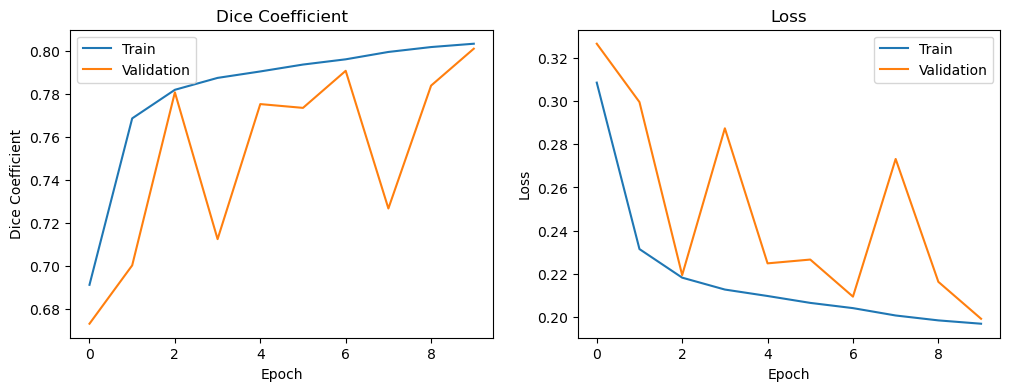

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 776ms/step - binary_accuracy: 0.8370 - dice_coef: 0.8131 - loss: 0.1869
Test Loss: 0.1963
Test Dice Coefficient: 0.8037
Test Accuracy: 0.8288


In [8]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


base_path = '/home/user/Rooftop dataset/with-overlap/prepared_dataset'
train_img_dir = os.path.join(base_path, 'train', 'images')
train_mask_dir = os.path.join(base_path, 'train', 'masks')
val_img_dir = os.path.join(base_path, 'val', 'images')
val_mask_dir = os.path.join(base_path, 'val', 'masks')
test_img_dir = os.path.join(base_path, 'test', 'images')
test_mask_dir = os.path.join(base_path, 'test', 'masks')


img_size = (512, 512)
batch_size = 32
epochs = 10

train_gen = ImageSegmentationGenerator(
    train_img_dir, train_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    augmentation=None,  
    shuffle=True
)

val_gen = ImageSegmentationGenerator(
    val_img_dir, val_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False
)

model = build_lightweight_unet(input_shape=img_size + (3,))

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=dice_loss,
    metrics=[dice_coef, 'binary_accuracy']
)

callbacks = [
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_dice_coef', mode='max'),
    EarlyStopping(patience=10, monitor='val_dice_coef', mode='max', restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, monitor='val_dice_coef', mode='max', min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    callbacks=callbacks
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

test_gen = ImageSegmentationGenerator(
    test_img_dir, test_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False
)

test_results = model.evaluate(test_gen)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")

In [21]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 512, 512,  │        224 │ input_layer_2[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         32 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 512, 512,  │        584 │ batch_normalizat… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 256, 256,  │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 256, 256,  │      1,168 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 128, 128,  │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_34[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 64, 64,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_2[0][0] 

 Total params: 122,817 (479.75 KB)

 Trainable params: 122,465 (478.38 KB)

 Non-trainable params: 352 (1.38 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
Accuracy: 0.8288
Precision: 0.7846
Recall: 0.8356
F1 Score: 0.8093

Confusion Matrix:
True Negative (TN): 27337215
False Positive (FP): 5854564
False Negative (FN): 4197133
True Positive (TP): 21331344
Specificity: 0.8236


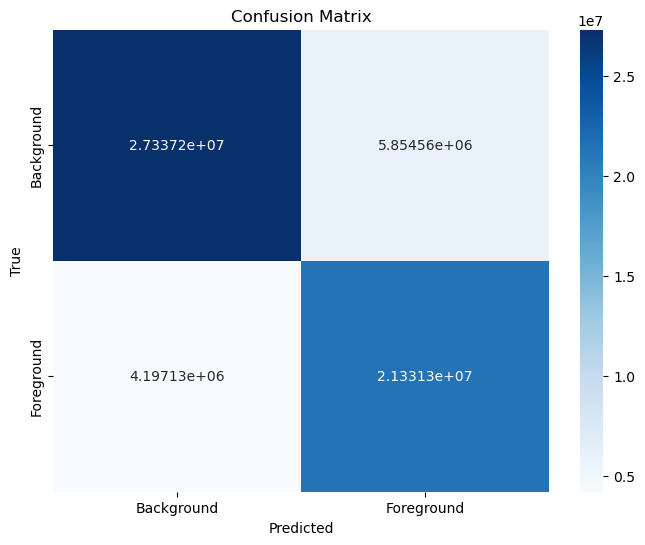

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step


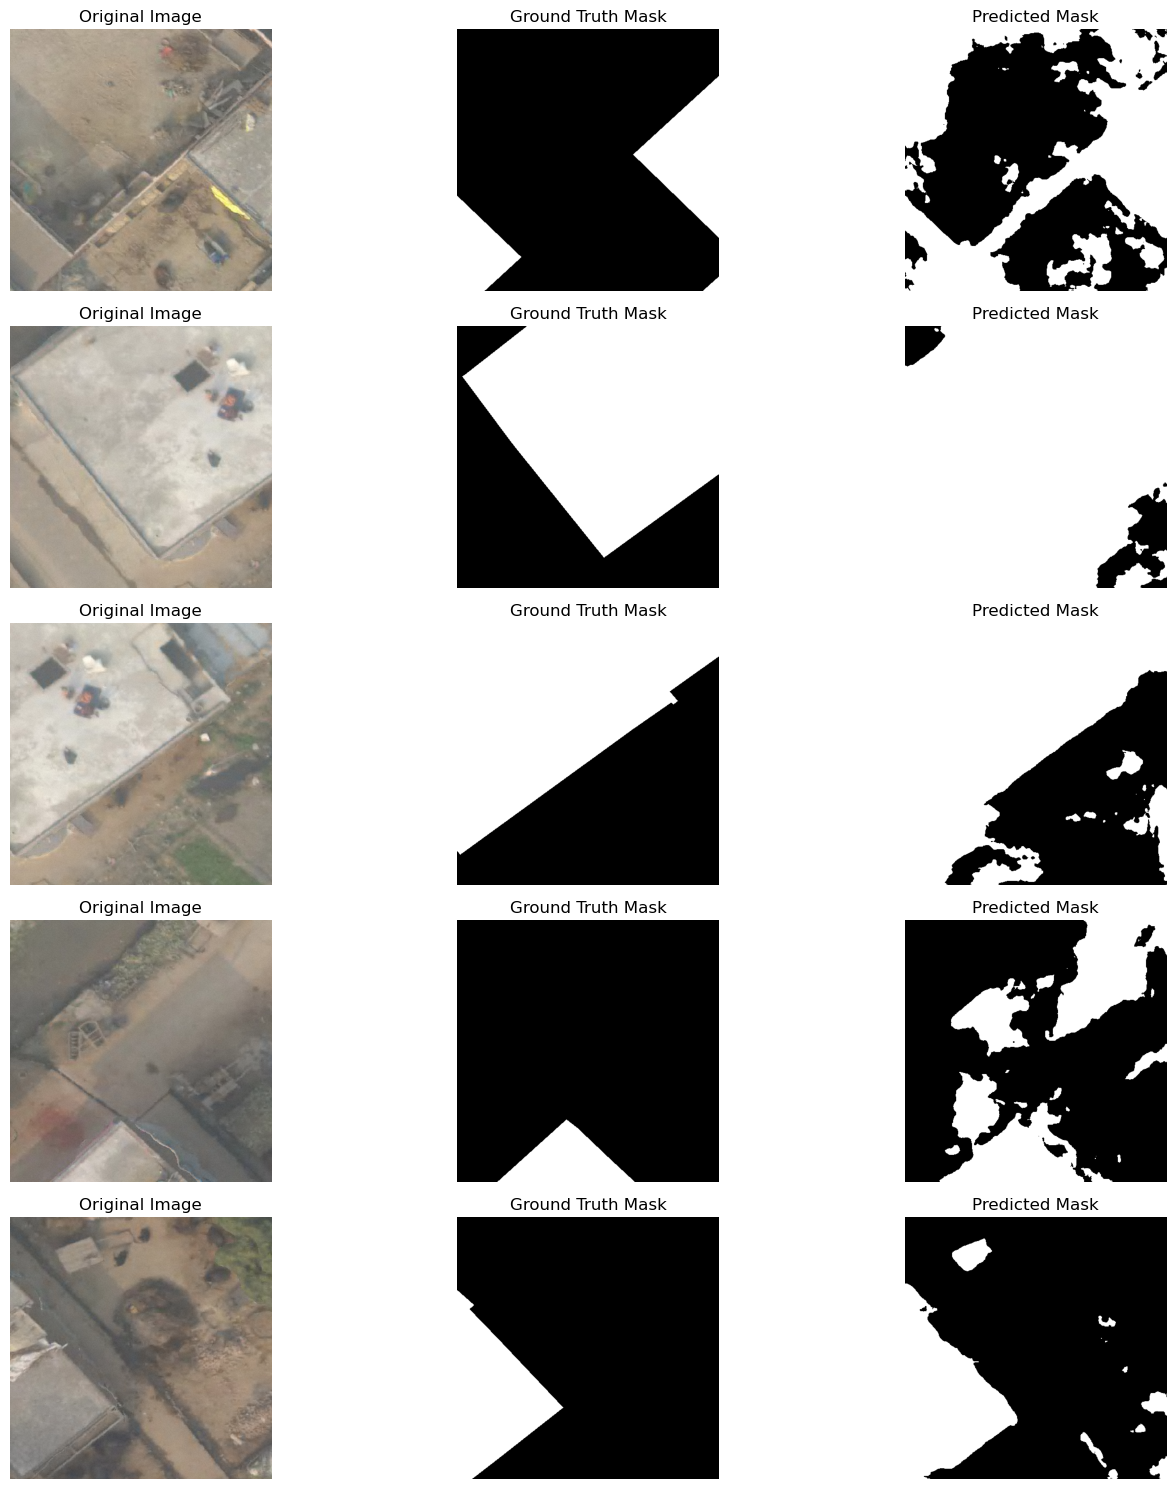

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


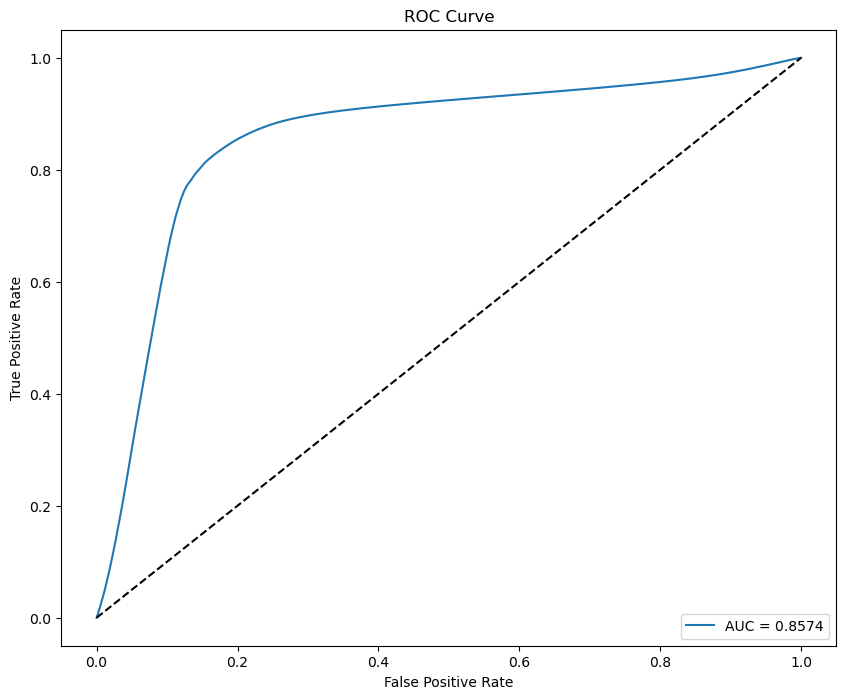

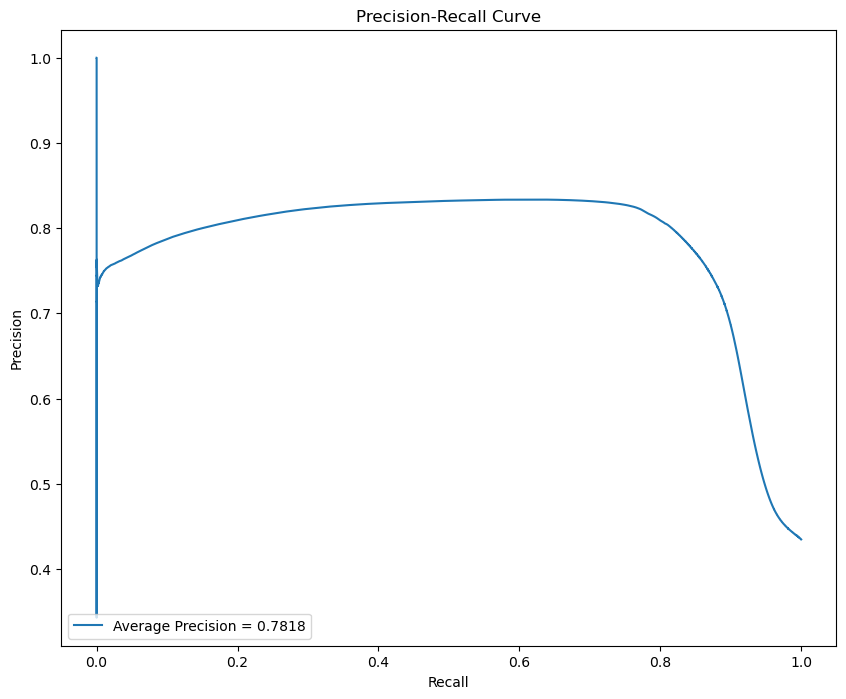

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model
import seaborn as sns

# Load the trained model
#model = load_model('best_model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# Set threshold for binary prediction
threshold = 0.5

# Function to get predictions and true labels from generator
def get_predictions_and_labels(generator, model, threshold=0.5):
    all_preds = []
    all_labels = []
    
    for i in range(len(generator)):
        batch_images, batch_masks = generator[i]
        batch_preds = model.predict(batch_images)
        
        # Apply threshold
        batch_preds_binary = (batch_preds > threshold).astype(np.uint8)
        
        # Flatten for metrics calculation
        all_preds.extend(batch_preds_binary.flatten())
        all_labels.extend(batch_masks.flatten())
    
    return np.array(all_preds), np.array(all_labels)

# Initialize test generator
test_gen = ImageSegmentationGenerator(
    test_img_dir, test_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False
)

# Get predictions and true labels
y_pred, y_true = get_predictions_and_labels(test_gen, model, threshold)

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

# Specificity (true negative rate)
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Background', 'Foreground'],
            yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize some predictions
def visualize_predictions(generator, model, num_samples=5, threshold=0.5):
    # Get a batch
    for images, masks in generator:
        break
    
    # Generate predictions
    predictions = model.predict(images)
    predictions_binary = (predictions > threshold).astype(np.uint8)
    
    # Show images, ground truth masks, and predicted masks
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(min(num_samples, len(images))):
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predictions_binary[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some test predictions
visualize_predictions(test_gen, model, num_samples=5, threshold=threshold)

# ROC curve and AUC calculation
from sklearn.metrics import roc_curve, roc_auc_score

# Get predictions (probabilities) and true labels
def get_prediction_probs(generator, model):
    all_probs = []
    all_labels = []
    
    for i in range(len(generator)):
        batch_images, batch_masks = generator[i]
        batch_preds = model.predict(batch_images)
        
        all_probs.extend(batch_preds.flatten())
        all_labels.extend(batch_masks.flatten())
    
    return np.array(all_probs), np.array(all_labels)

# Get probabilities
y_prob, y_true_roc = get_prediction_probs(test_gen, model)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob)
auc = roc_auc_score(y_true_roc, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, _ = precision_recall_curve(y_true_roc, y_prob)
avg_precision = average_precision_score(y_true_roc, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
Mean IoU: 0.6485
Accuracy: 0.8288
Precision: 0.7846
Recall: 0.8356
F1 Score: 0.8093

Confusion Matrix:
True Negative (TN): 27337215
False Positive (FP): 5854564
False Negative (FN): 4197133
True Positive (TP): 21331344
Specificity: 0.8236


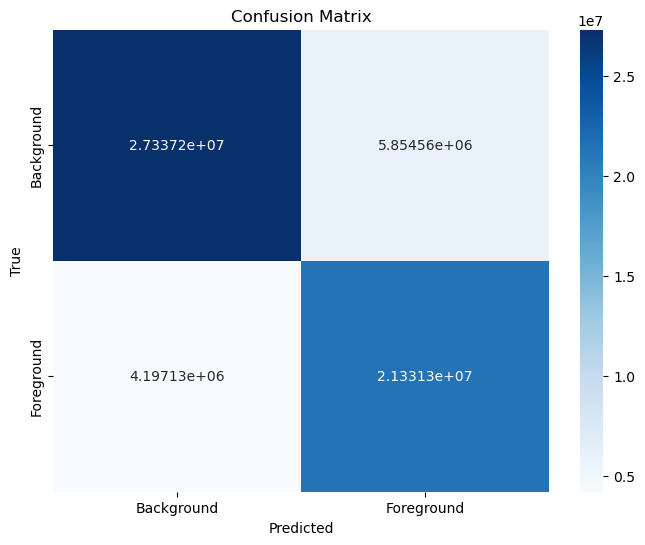

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


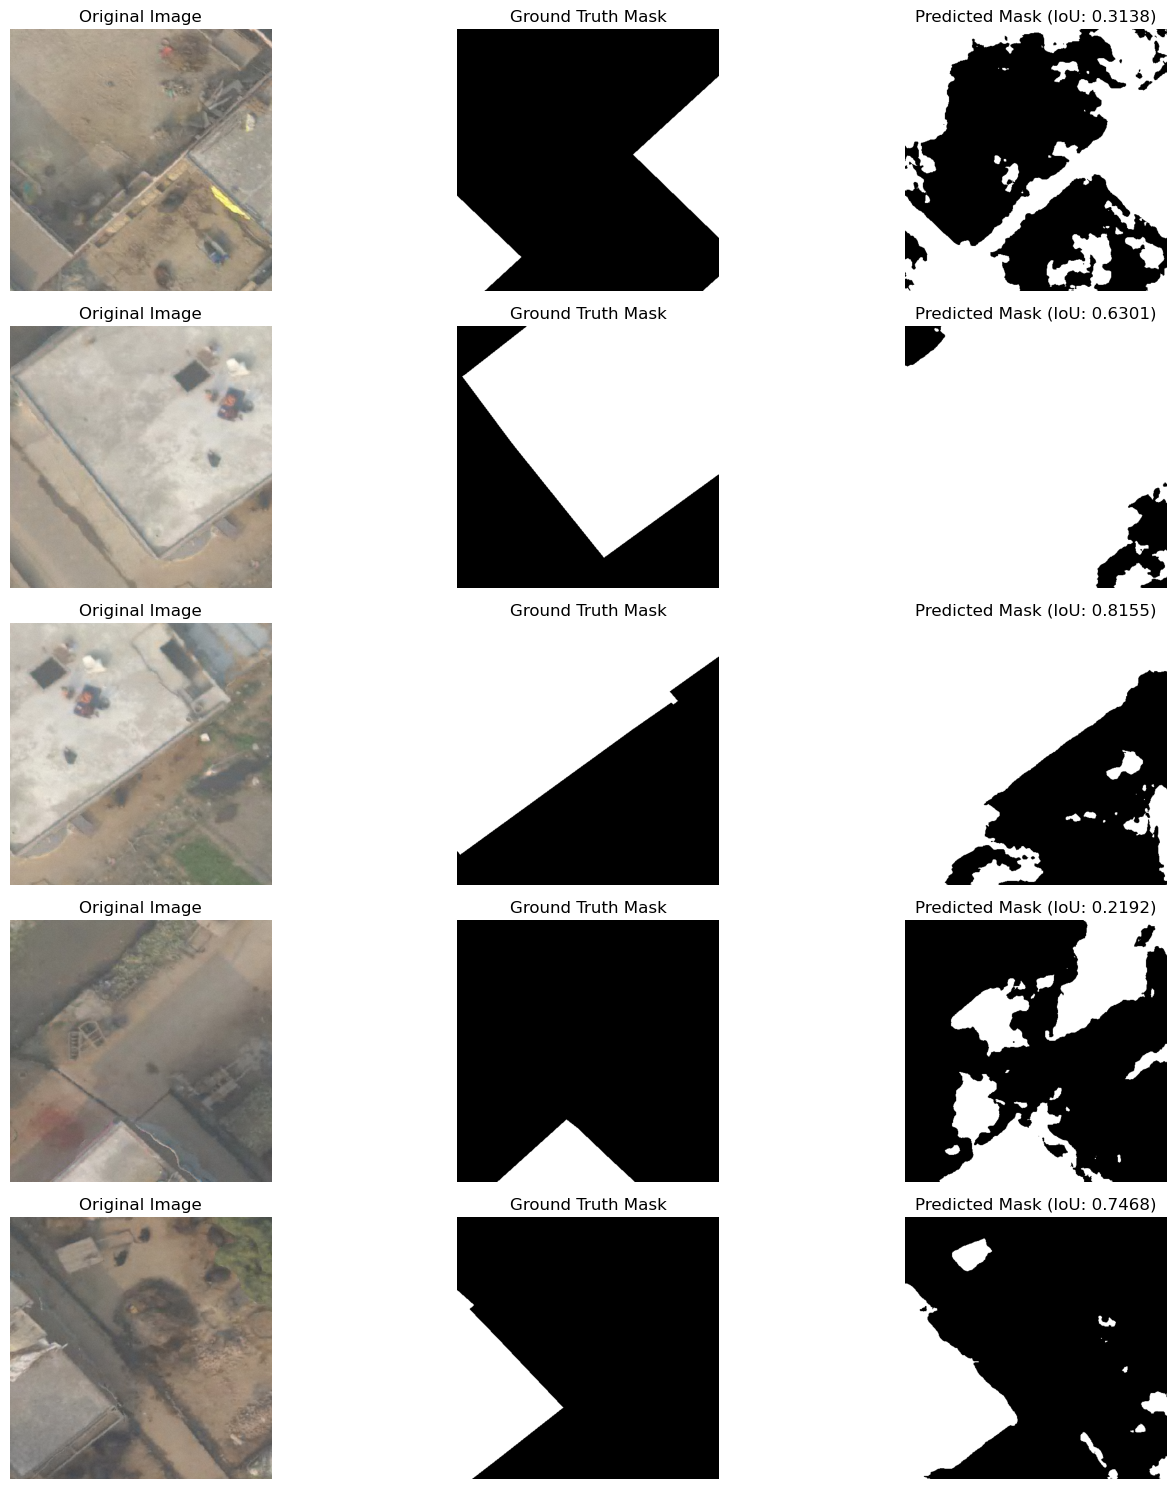

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


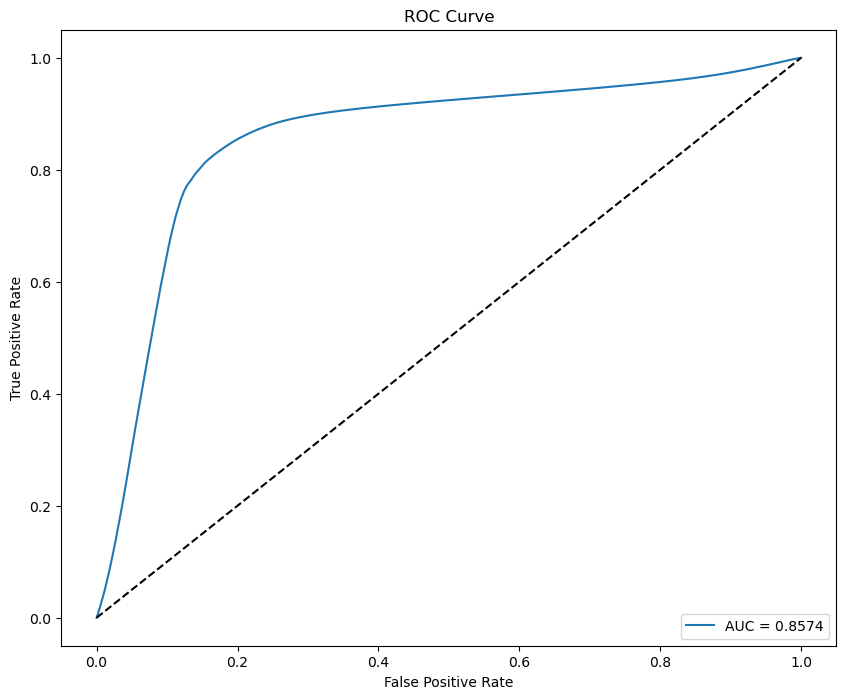

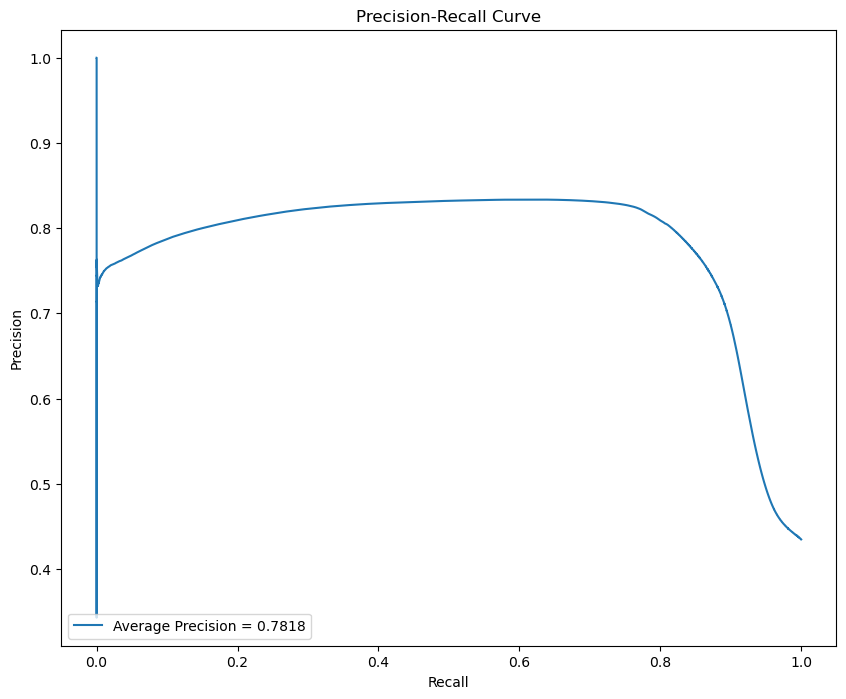

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model
import seaborn as sns

# Load the trained model
#model = load_model('best_model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# Set threshold for binary prediction
threshold = 0.5

# Function to calculate IoU (Jaccard Index)
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0.0
    return intersection / union

# Function to get predictions and true labels from generator
def get_predictions_and_labels(generator, model, threshold=0.5):
    all_preds = []
    all_labels = []
    batch_ious = []
    
    for i in range(len(generator)):
        batch_images, batch_masks = generator[i]
        batch_preds = model.predict(batch_images)
        
        # Apply threshold
        batch_preds_binary = (batch_preds > threshold).astype(np.uint8)
        
        # Calculate IoU for each image in the batch
        for j in range(len(batch_images)):
            true = batch_masks[j].flatten()
            pred = batch_preds_binary[j].flatten()
            batch_ious.append(iou_score(true, pred))
        
        # Flatten for metrics calculation
        all_preds.extend(batch_preds_binary.flatten())
        all_labels.extend(batch_masks.flatten())
    
    mean_iou = np.mean(batch_ious)
    return np.array(all_preds), np.array(all_labels), mean_iou

# Initialize test generator
test_gen = ImageSegmentationGenerator(
    test_img_dir, test_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False
)

# Get predictions and true labels
y_pred, y_true, mean_iou = get_predictions_and_labels(test_gen, model, threshold)

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Mean IoU: {mean_iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negative (TN): {tn}")
print(f"False Positive (FP): {fp}")
print(f"False Negative (FN): {fn}")
print(f"True Positive (TP): {tp}")

# Specificity (true negative rate)
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

# Visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Background', 'Foreground'],
            yticklabels=['Background', 'Foreground'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize some predictions and include IoU scores
def visualize_predictions(generator, model, num_samples=5, threshold=0.5):
    # Get a batch
    for images, masks in generator:
        break
    
    # Generate predictions
    predictions = model.predict(images)
    predictions_binary = (predictions > threshold).astype(np.uint8)
    
    # Show images, ground truth masks, predicted masks, and IoU scores
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(min(num_samples, len(images))):
        # Calculate IoU for this image
        true_mask = masks[i].flatten()
        pred_mask = predictions_binary[i].flatten()
        iou = iou_score(true_mask, pred_mask)
        
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Predicted mask with IoU score
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predictions_binary[i].squeeze(), cmap='gray')
        plt.title(f'Predicted Mask (IoU: {iou:.4f})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some test predictions with IoU scores
visualize_predictions(test_gen, model, num_samples=5, threshold=threshold)

# ROC curve and AUC calculation
from sklearn.metrics import roc_curve, roc_auc_score

# Get predictions (probabilities) and true labels
def get_prediction_probs(generator, model):
    all_probs = []
    all_labels = []
    
    for i in range(len(generator)):
        batch_images, batch_masks = generator[i]
        batch_preds = model.predict(batch_images)
        
        all_probs.extend(batch_preds.flatten())
        all_labels.extend(batch_masks.flatten())
    
    return np.array(all_probs), np.array(all_labels)

# Get probabilities
y_prob, y_true_roc = get_prediction_probs(test_gen, model)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_roc, y_prob)
auc = roc_auc_score(y_true_roc, y_prob)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_curve, recall_curve, _ = precision_recall_curve(y_true_roc, y_prob)
avg_precision = average_precision_score(y_true_roc, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


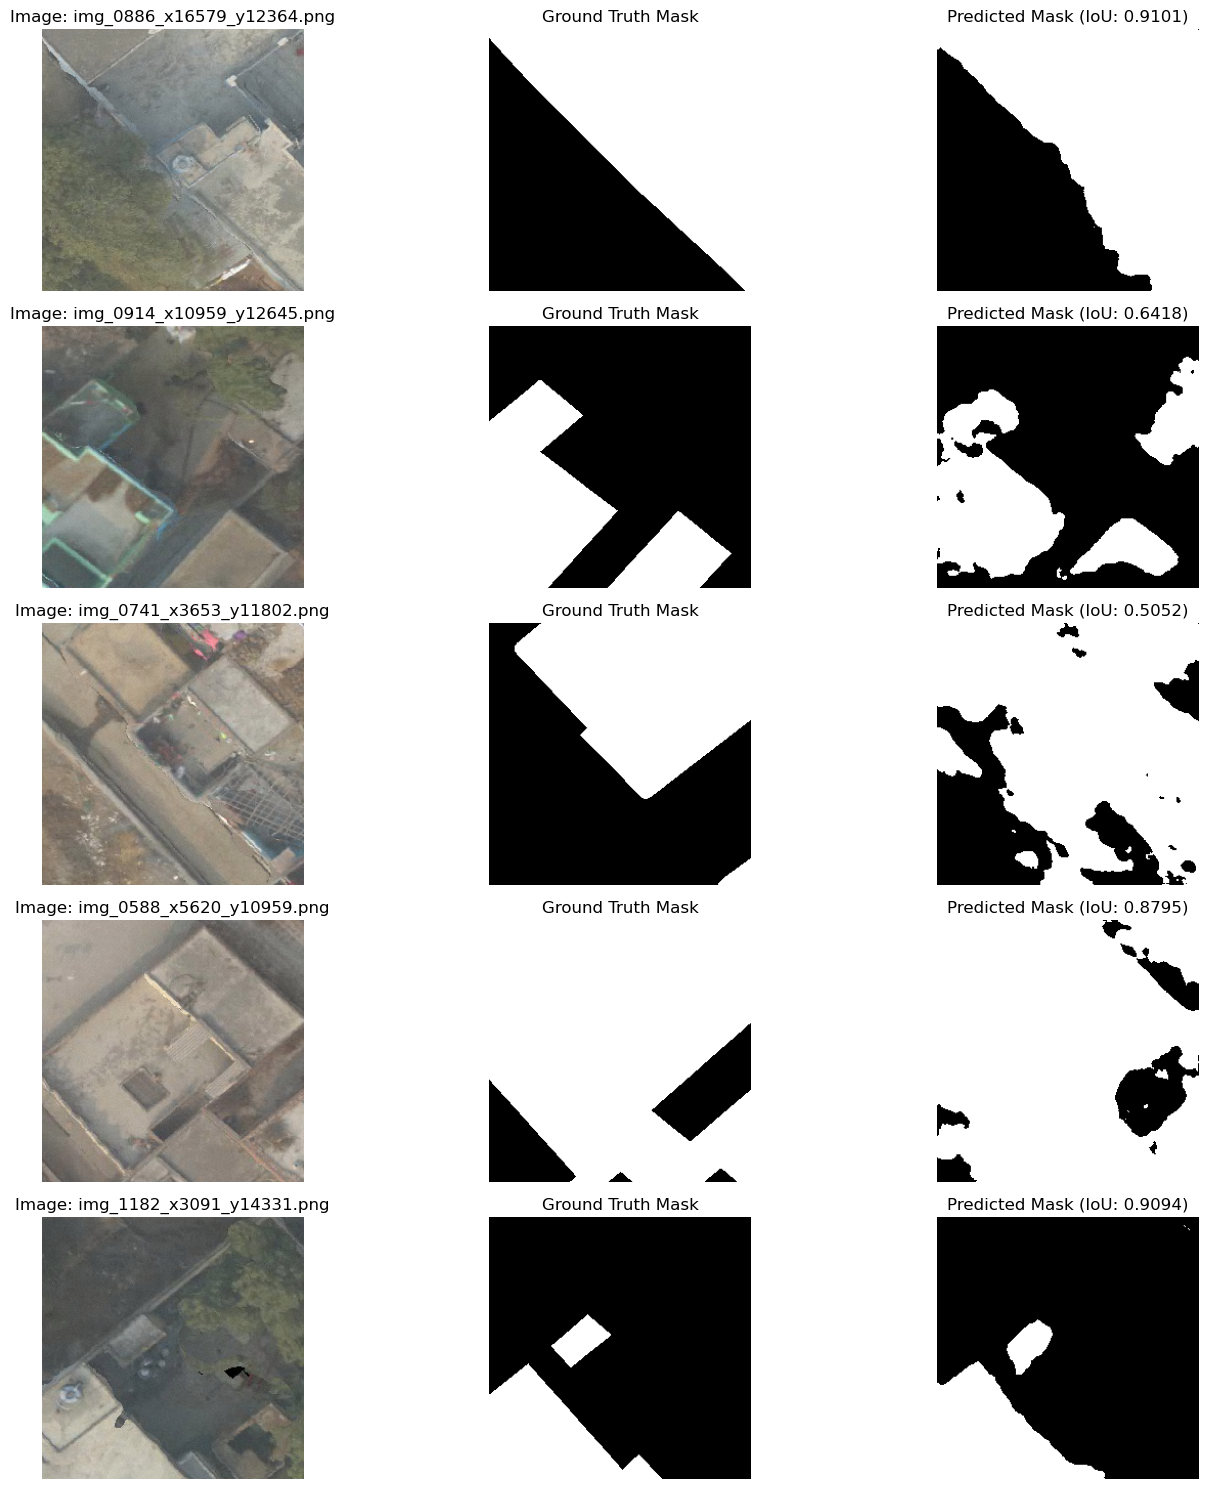


Randomly selected images:
1. img_0886_x16579_y12364.png
2. img_0914_x10959_y12645.png
3. img_0741_x3653_y11802.png
4. img_0588_x5620_y10959.png
5. img_1182_x3091_y14331.png


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model
import os

# Load the trained model
#model = load_model('best_model.h5', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

# Function to calculate IoU (Jaccard Index)
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 0.0
    return intersection / union

# Function to visualize predictions for randomly selected images
def visualize_random_predictions(test_img_dir, test_mask_dir, model, num_samples=5, threshold=0.5, img_size=(256, 256)):
    # Get all image filenames
    img_files = sorted(os.listdir(test_img_dir))
    mask_files = sorted(os.listdir(test_mask_dir))
    
    # Get random indexes
    total_images = len(img_files)
    if num_samples > total_images:
        num_samples = total_images
        print(f"Warning: Only {total_images} images available in test dir. Showing all of them.")
    
    random_indexes = random.sample(range(total_images), num_samples)
    
    # Create figure
    plt.figure(figsize=(15, num_samples * 3))
    
    for i, idx in enumerate(random_indexes):
        # Load image
        img_path = os.path.join(test_img_dir, img_files[idx])
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        
        # Load mask
        mask_path = os.path.join(test_mask_dir, mask_files[idx])
        mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
        mask_array = img_to_array(mask) / 255.0
        
        # Get prediction
        img_batch = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_batch)
        pred_binary = (pred > threshold).astype(np.uint8)
        
        # Calculate IoU for this image
        true_mask = mask_array.flatten()
        pred_mask = pred_binary[0].flatten()
        iou = iou_score(true_mask, pred_mask)
        
        # Show original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_array)
        plt.title(f'Image: {img_files[idx]}')
        plt.axis('off')
        
        # Show ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_array.squeeze(), cmap='gray')
        plt.title(f'Ground Truth Mask')
        plt.axis('off')
        
        # Show predicted mask with IoU
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred_binary[0].squeeze(), cmap='gray')
        plt.title(f'Predicted Mask (IoU: {iou:.4f})')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return random_indexes, img_files

# Visualize random test predictions
random_indexes, img_files = visualize_random_predictions(test_img_dir, test_mask_dir, model, num_samples=5, threshold=0.5)

# Print out the selected image filenames for reference
print("\nRandomly selected images:")
for i, idx in enumerate(random_indexes):
    print(f"{i+1}. {img_files[idx]}")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Evaluate on test set
test_gen = ImageSegmentationGenerator(
    test_img_dir, test_mask_dir,
    batch_size=batch_size,
    img_size=img_size,
    shuffle=False
)

test_results = model.evaluate(test_gen)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Dice Coefficient: {test_results[1]:.4f}")
print(f"Test Accuracy: {test_results[2]:.4f}")

# old code without validation split

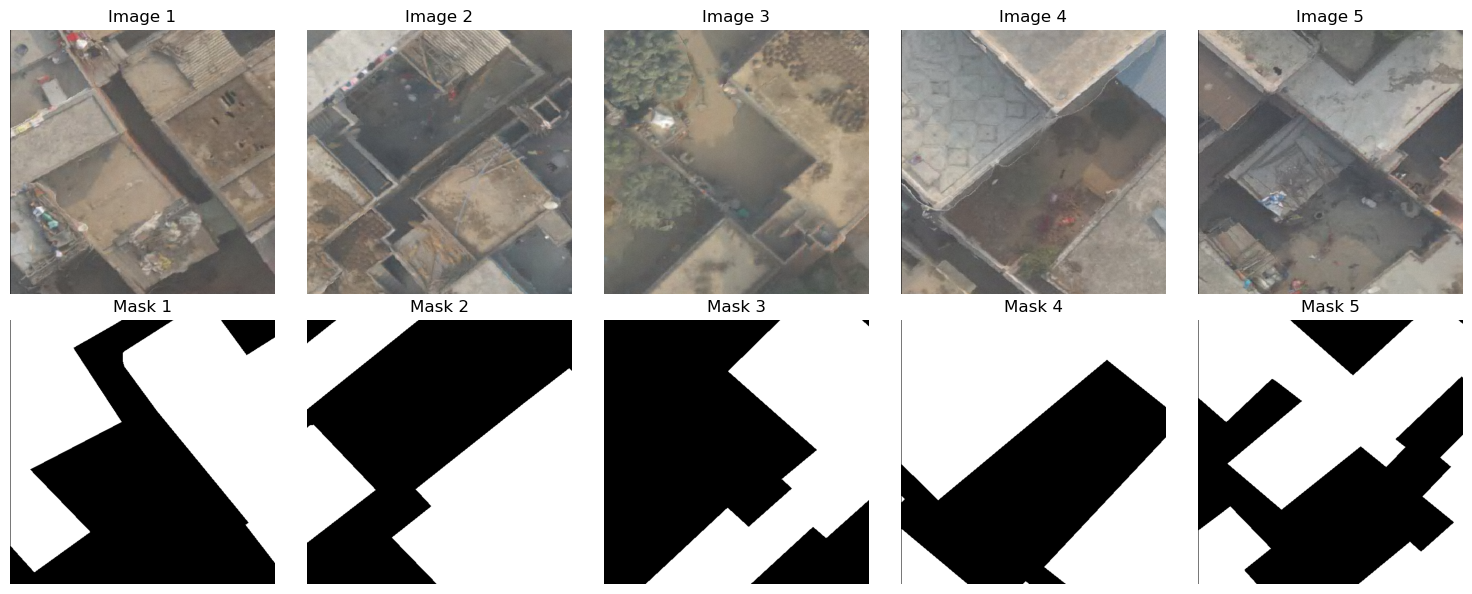


Visualized samples:
- img_1107_x7868_y13769_aug4.png
- img_0688_x4215_y11521_aug0.png
- img_0064_x11240_y6744_aug1.png
- img_1396_x10678_y16298_aug4.png
- img_0918_x12083_y12645_aug4.png


In [29]:
import matplotlib.pyplot as plt
import random
import glob
from pathlib import Path
import cv2
import numpy as np

def visualize_random_samples(train_dir, num_samples=5):
    """
    Visualize random samples from training data
    """
    # Get all training images and their corresponding masks
    train_dir = Path(train_dir)
    image_files = sorted(glob.glob(str(train_dir / 'images' / '*.png')))
    
    # Randomly select samples
    selected_files = random.sample(image_files, num_samples)
    
    # Create figure
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for idx, img_path in enumerate(selected_files):
        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Get corresponding mask path and read mask
        mask_path = str(train_dir / 'masks' / Path(img_path).name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Plot image
        axes[0, idx].imshow(img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Image {idx+1}')
        
        # Plot mask
        axes[1, idx].imshow(mask, cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Mask {idx+1}')
    
    plt.tight_layout()
    plt.show()
    
    return selected_files

# Example usage
random_samples = visualize_random_samples(
    train_dir='/home/user/Rooftop dataset/with-overlap/prepared_dataset/train',
    num_samples=5
)

# Print the filenames of visualized samples
print("\nVisualized samples:")
for file in random_samples:
    print(f"- {Path(file).name}")

In [66]:
import os
import cv2
import numpy as np

def data_generator(image_files, mask_files, batch_size=32):
    while True:  # Loop indefinitely
        for start in range(0, len(image_files), batch_size):
            end = min(start + batch_size, len(image_files))
            batch_image_files = image_files[start:end]
            batch_mask_files = mask_files[start:end]
            X_batch = []
            y_batch = []
            for img_file in batch_image_files:
                img = cv2.imread(img_file)
                img = cv2.resize(img, (512, 512))  # Ensure the image is resized correctly
                img = img / 255.0  # Normalize
                X_batch.append(img)
            for mask_file in batch_mask_files:
                mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (512, 512))  # Ensure the mask is resized correctly
                mask = mask / 255.0  # Normalize
                y_batch.append(mask)
            # Convert to numpy arrays
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)
            # Print the shapes of the batches
            print(f"X_batch shape: {X_batch.shape}, y_batch shape: {y_batch.shape}")
            yield X_batch, y_batch

# def data_generator(image_files, mask_files, batch_size=32):
#     while True:  # Loop indefinitely
#         for start in range(0, len(image_files), batch_size):
#             end = min(start + batch_size, len(image_files))
#             batch_image_files = image_files[start:end]
#             batch_mask_files = mask_files[start:end]
            
#             X_batch = []
#             y_batch = []
            
#             for img_file in batch_image_files:
#                 img = cv2.imread(img_file)
#                 img = img / 255.0  # Normalize
#                 X_batch.append(img)
                
#             for mask_file in batch_mask_files:
#                 mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
#                 mask = mask / 255.0  # Normalize
#                 y_batch.append(mask)
                
#             yield np.array(X_batch), np.array(y_batch)

# Define your paths as before
train_image_folder = '/home/user/Rooftop dataset/with-overlap/prepared_dataset/train/images/'
train_mask_folder = '/home/user/Rooftop dataset/with-overlap/prepared_dataset/train/masks/'
test_image_folder = '/home/user/Rooftop dataset/with-overlap/prepared_dataset/test/images/'
test_mask_folder = '/home/user/Rooftop dataset/with-overlap/prepared_dataset/test/masks/'

# Get the list of image and mask files
train_image_files = [os.path.join(train_image_folder, f) for f in os.listdir(train_image_folder) if f.endswith('.png')]
train_mask_files = [os.path.join(train_mask_folder, f) for f in os.listdir(train_mask_folder) if f.endswith('.png')]
test_image_files = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith('.png')]
test_mask_files = [os.path.join(test_mask_folder, f) for f in os.listdir(test_mask_folder) if f.endswith('.png')]

# Create the data generators
train_gen = data_generator(train_image_files, train_mask_files, batch_size=32)
test_gen = data_generator(test_image_files, test_mask_files, batch_size=32)

# Example of how to use the generator in a training loop
# Assuming you have a model defined
# model.fit(train_gen, steps_per_epoch=len(train_image_files) // 32, epochs=10)

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the input shape
input_shape = (512, 512, 3)  # Adjust based on your image size
model = unet_model(input_shape)
model.summary()  # Print the model summary

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │        224 │ input_layer_1[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │        584 │ conv2d_19[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │      1,168 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_21[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_23[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_25[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_27[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │     32,832 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 485,817 (1.85 MB)

 Trainable params: 485,817 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [16]:
# Define the number of epochs and batch size
epochs = 10  # Adjust based on your needs
batch_size = 64  # Should match the batch size used in the generator

# Train the model using the generator
history = model.fit(train_gen, 
                    steps_per_epoch=len(train_image_files) // batch_size, 
                    epochs=epochs, 
                    validation_data=test_gen, 
                    validation_steps=len(test_image_files) // batch_size)

Epoch 1/10


/home/user/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)


146/146 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.6083 - loss: 0.6604 - val_accuracy: 0.7223 - val_loss: 0.5435
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7888 - loss: 0.4628 - val_accuracy: 0.8147 - val_loss: 0.4100
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.8034 - loss: 0.4308 - val_accuracy: 0.8236 - val_loss: 0.3947
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.8172 - loss: 0.4123 - val_accuracy: 0.8019 - val_loss: 0.4451
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.8257 - loss: 0.3951 - val_accuracy: 0.8407 - val_loss: 0.3726
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 287s 2s/step - accuracy: 0.8337 - loss: 0.3803 - val_accuracy: 0.8338 - val_loss: 0.3630
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.8363 - loss: 0.3757 - val_accuracy: 0.8569 - val_loss: 0.3397
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.8464 - loss: 0.3576 - val_accuracy: 0.848

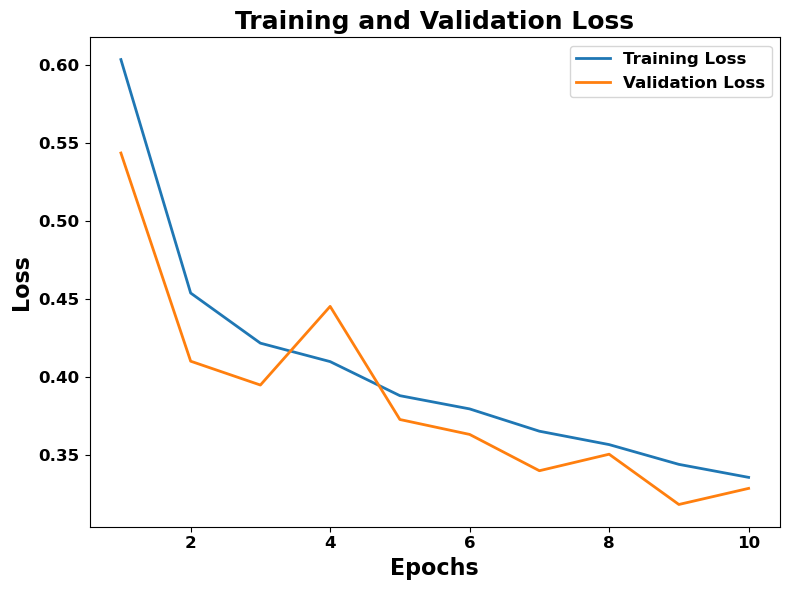

In [22]:
from matplotlib import pyplot as plt
''' graph of val_loss and train_loss ''' 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, '-', label="Training Loss", linewidth=2)
plt.plot(epochs, val_loss, '-', label="Validation Loss", linewidth=2)
plt.title("Training and Validation Loss", fontweight = "bold", fontsize = 18)
plt.xlabel('Epochs', fontweight = 'bold', fontsize = 16)
plt.ylabel('Loss', fontweight = 'bold', fontsize = 16)
plt.legend(loc = 'upper right', prop={'weight':'bold', 'size':12})
plt.xticks(fontsize = 12, fontweight='bold')
plt.yticks(fontsize = 12, fontweight='bold')
plt.tight_layout()
plt.show()

In [26]:
model.save("/home/user/Rooftop dataset/with-overlap/128model10E.keras")

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_gen, steps=len(test_image_files) // batch_size)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 552ms/step - accuracy: 0.8468 - loss: 0.3571
Test Loss: 0.352089524269104, Test Accuracy: 0.8500469326972961


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


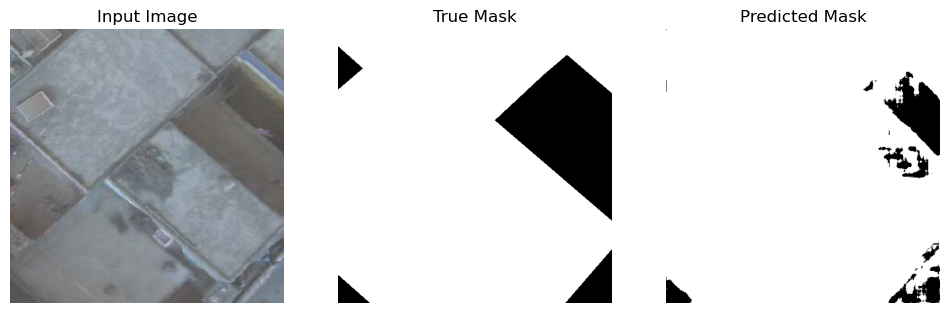

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


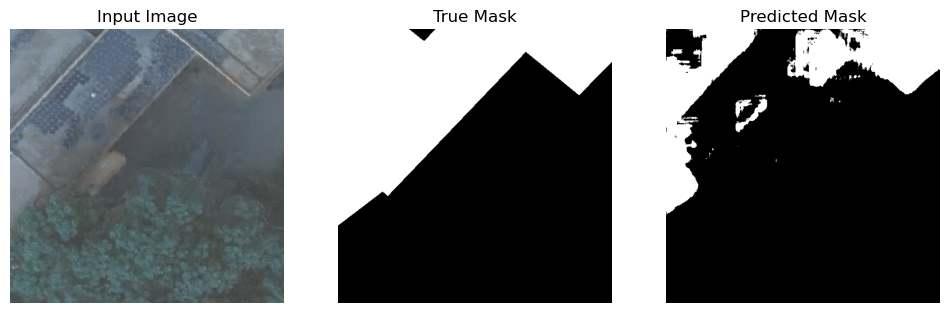

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


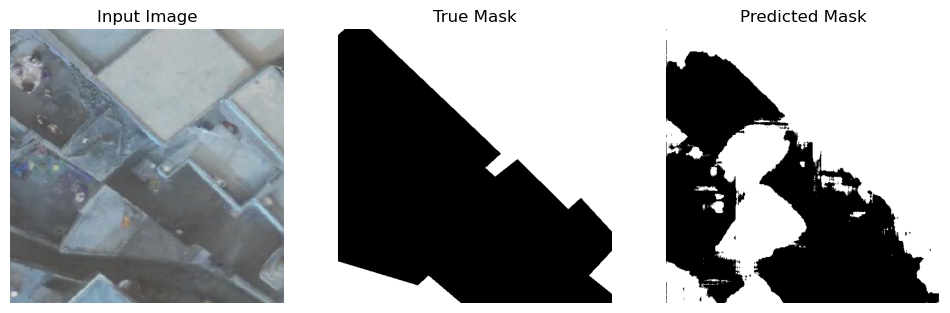

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


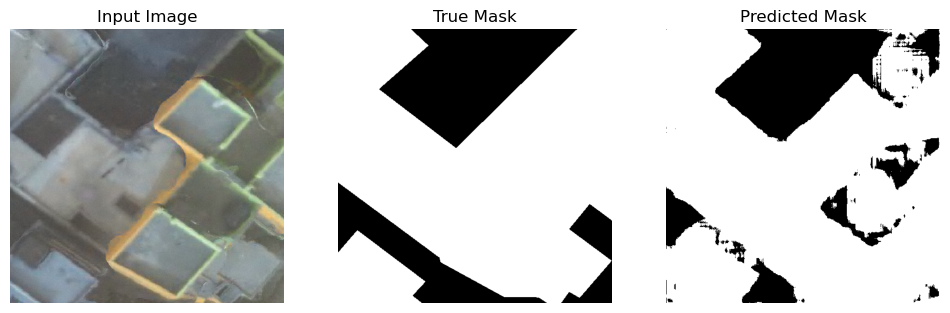

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


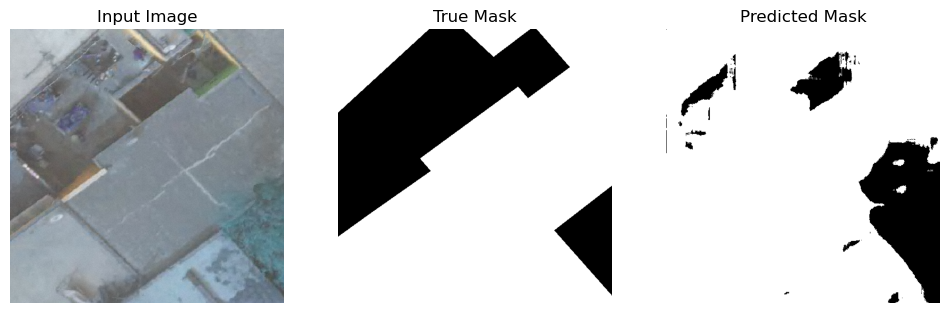

In [36]:
import matplotlib.pyplot as plt

def visualize_predictions(test_image_files, test_mask_files, model, num_images=5):
    for i in range(num_images):
        img = cv2.imread(test_image_files[i])
        img_resized = cv2.resize(img, (512, 512)) / 255.0  
        img_input = np.expand_dims(img_resized, axis=0)  

        predicted_mask = model.predict(img_input)
        predicted_mask = (predicted_mask[0] > 0.5).astype(np.uint8) * 255  # Convert to binary mask

        true_mask = cv2.imread(test_mask_files[i], cv2.IMREAD_GRAYSCALE)

        # Plot the results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(img_resized)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(true_mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask, cmap='gray')
        plt.axis('off')

        plt.show()

# Visualize predictions
visualize_predictions(test_image_files, test_mask_files, model, num_images=5)

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the true masks and convert them to binary classes
y_test_classes = []
for mask_file in test_mask_files:
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask_binary = (mask > 127).astype(np.uint8)  # Convert to binary (0 or 1)
    y_test_classes.append(mask_binary.flatten())  # Flatten to 1D array

y_test_classes = np.array(y_test_classes)

# Make predictions on the test set
y_pred_prob = model.predict(test_gen, steps=len(test_image_files) // batch_size)

# Check the shape of predicted probabilities
print(f"Shape of predicted probabilities: {y_pred_prob.shape}")

# Convert probabilities to binary classes
y_pred_classes = (y_pred_prob > 0.5).astype(np.uint8)

# Concatenate the predicted classes to match the number of true labels
y_pred_classes = y_pred_classes.reshape(-1)  # Flatten to 1D array

# Check shapes of true and predicted labels
print(f"Shape of true labels: {y_test_classes.shape}")
print(f"Shape of predicted labels: {y_pred_classes.shape}")

# Ensure both arrays are flattened correctly
if y_test_classes.size != y_pred_classes.size:
    print("Mismatch in number of samples!")
else:
    # Now you can create the confusion matrix
    cm = confusion_matrix(y_test_classes.flatten(), y_pred_classes)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix', fontsize=15)
    plt.xlabel('Predicted', fontsize=11)
    plt.ylabel('Actual', fontsize=11)
    plt.show()

    # Calculate evaluation metrics
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()
    precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
    recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step
Shape of predicted probabilities: (160, 512, 512, 1)
Shape of true labels: (336, 262144)
Shape of predicted labels: (41943040,)
Mismatch in number of samples!


In [58]:
# After making predictions
print(f"Predicted probabilities shape: {y_pred_prob.shape}")

# After converting to binary classes
print(f"Predicted classes shape: {y_pred_classes.shape}")

# After flattening true labels
print(f"True labels shape after flattening: {y_test_classes.flatten().shape}")

Predicted probabilities shape: (144, 512, 512, 1)
Predicted classes shape: (37748736,)
True labels shape after flattening: (88080384,)


In [56]:
# Ensure the predicted classes are reshaped correctly
y_pred_classes = y_pred_classes.reshape(-1)  # Flatten to 1D array

In [35]:
import os
import cv2
import numpy as np
from glob import glob
from tensorflow.keras.utils import Sequence

class ImageDataGenerator(Sequence):
    """
    Memory-efficient data generator that loads images in batches.
    """
    def __init__(self, image_files, mask_files, batch_size=32, shuffle=True):
        self.image_files = image_files
        self.mask_files = mask_files
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(image_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, idx):
        # Get batch indexes
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        # Initialize batch arrays
        batch_images = []
        batch_masks = []
        
        # Load and process images for this batch
        for i in batch_indexes:
            # Load image
            image = cv2.imread(self.image_files[i])
            image = image.astype('float32') / 255.0
            
            # Load mask
            mask = cv2.imread(self.mask_files[i], cv2.IMREAD_GRAYSCALE)
            mask = mask.astype('float32') / 255.0
            
            batch_images.append(image)
            batch_masks.append(mask)
        
        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        """Shuffle indexes after each epoch if shuffle is set to True."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

def prepare_data_generators(base_path, batch_size=32):
    """
    Prepare train and test data generators.
    """
    # Define paths
    train_image_path = os.path.join(base_path, 'train', 'images', '*')
    train_mask_path = os.path.join(base_path, 'train', 'masks', '*')
    test_image_path = os.path.join(base_path, 'test', 'images', '*')
    test_mask_path = os.path.join(base_path, 'test', 'masks', '*')
    
    # Get sorted file lists
    train_image_files = sorted(glob(train_image_path))
    train_mask_files = sorted(glob(train_mask_path))
    test_image_files = sorted(glob(test_image_path))
    test_mask_files = sorted(glob(test_mask_path))
    
    # Validate that we found files
    if not train_image_files:
        raise ValueError(f"No training images found in {train_image_path}")
    
    # Create generators
    train_generator = ImageDataGenerator(
        train_image_files, 
        train_mask_files, 
        batch_size=batch_size,
        shuffle=True
    )
    
    test_generator = ImageDataGenerator(
        test_image_files, 
        test_mask_files, 
        batch_size=batch_size,
        shuffle=False
    )
    
    print(f"Found {len(train_image_files)} training images")
    print(f"Found {len(test_image_files)} test images")
    
    return train_generator, test_generator

In [41]:
# Specify path and batch size
base_path = '/home/user/Rooftop dataset/with-overlap/prepared_dataset'
batch_size = 32  # Adjust based on your GPU/CPU memory

# Create data generators
train_generator, test_generator = prepare_data_generators(base_path, batch_size=batch_size)

# # Use generators in model.fit()
# model.fit(
#     train_generator,
#     validation_data=test_generator,
#     epochs=50
# )

Found 9394 training images
Found 336 test images


ValueError: You must call `compile()` before using the model.

In [ ]:
print("x_train shape: ", X_train.shpae)
print("y_train shape: ", y_trai

In [43]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_unet(input_size=(512, 512, 3)):
    """Build U-Net architecture"""
    inputs = Input(input_size)
    
    # Encoder (Contracting Path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder (Expansive Path)
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 512, 512,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 512, 512,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 256, 256,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 256, 256,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 256, 256,  │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 128, 128,  │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 128, 128,  │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 32, 32,    │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 32, 32,    │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 64, 64,    │  2,097,664 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
steps_per_epoch = len(glob.glob('/home/user/Rooftop dataset/with-overlap/prepared_dataset/train/images/*.png')) // 8
model, history = train_unet_with_generator(train_generator, steps_per_epoch)

AttributeError: 'function' object has no attribute 'glob'

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define the input shape
input_shape = (512, 512, 3)  # Adjust based on your image size
model = unet_model(input_shape)
model.summary()  # Print the model summary

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 512, 512,  │        224 │ input_layer_2[0]… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 512, 512,  │        584 │ conv2d_38[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 256, 256,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 256, 256,  │      1,168 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_40[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 128,  │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_9[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_42[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_44[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_11… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_46[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 64, 64,    │     32,832 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 485,817 (1.85 MB)

 Trainable params: 485,817 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy

def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=[dice_coefficient, MeanIoU(num_classes=2), 'accuracy']
)

In [51]:
model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50
)

/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/home/user/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_64']
Received: inputs=Tensor(shape=(None, 512, 512, 3))
  warnings.warn(msg)
2025-02-17 14:55:32.603877: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: INVALID_ARGUMENT: Incompatible shapes: [32,512,512] vs. [32,512,512,1]
	 [[{{function_node __inference_one_step_on_data_9228}}{{node mul_1}}]]


InvalidArgumentError: Graph execution error:

Detected at node mul_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/user/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/user/anaconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/user/anaconda3/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/home/user/anaconda3/lib/python3.12/asyncio/base_events.py", line 1986, in _run_once

  File "/home/user/anaconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/user/anaconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/user/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_28739/182381839.py", line 1, in <module>

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 84, in train_step

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/trainer.py", line 490, in compute_metrics

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 334, in update_state

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/trainers/compile_utils.py", line 21, in update_state

  File "/home/user/anaconda3/lib/python3.12/site-packages/keras/src/metrics/reduction_metrics.py", line 203, in update_state

  File "/tmp/ipykernel_28739/3444217689.py", line 5, in dice_coefficient

Incompatible shapes: [32,512,512] vs. [32,512,512,1]
	 [[{{node mul_1}}]] [Op:__inference_multi_step_on_iterator_9529]

In [ ]:
#######################spit new

In [29]:
import os
import cv2
import numpy as np
from glob import glob

def load_dataset(base_path):
    """
    Load images and masks from the specified directory structure.
    
    Expected structure:
    base_path/
        train/
            images/
            mask/
        test/
            images/
            mask/
    
    Returns:
        X_train, y_train, X_test, y_test: Normalized numpy arrays
    """
    # Define paths for train and test data
    train_image_path = os.path.join(base_path, 'train', 'images', '*')
    train_mask_path = os.path.join(base_path, 'train', 'masks', '*')
    test_image_path = os.path.join(base_path, 'test', 'images', '*')
    test_mask_path = os.path.join(base_path, 'test', 'masks', '*')
    
    # Get file lists
    train_image_files = sorted(glob(train_image_path))
    train_mask_files = sorted(glob(train_mask_path))
    test_image_files = sorted(glob(test_image_path))
    test_mask_files = sorted(glob(test_mask_path))
    
    # Validate that we found files
    if not train_image_files:
        raise ValueError(f"No training images found in {train_image_path}")
    if not train_mask_files:
        raise ValueError(f"No training masks found in {train_mask_path}")
    if not test_image_files:
        raise ValueError(f"No test images found in {test_image_path}")
    if not test_mask_files:
        raise ValueError(f"No test masks found in {test_mask_path}")
    
    # Load and normalize images
    X_train = np.array([cv2.imread(file) for file in train_image_files])
    y_train = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in train_mask_files])
    X_test = np.array([cv2.imread(file) for file in test_image_files])
    y_test = np.array([cv2.imread(file, cv2.IMREAD_GRAYSCALE) for file in test_mask_files])
    
    # Normalize the data
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    y_train = y_train / 255.0
    y_test = y_test / 255.0
    
    print(f"Loaded {len(X_train)} training samples and {len(X_test)} test samples")
    print(f"Image shape: {X_train[0].shape}, Mask shape: {y_train[0].shape}")
    
    return X_train, y_train, X_test, y_test

In [31]:
# Specify the path to your prepared_dataset folder
base_path = '/home/user/Rooftop dataset/with-overlap/prepared_dataset'

# Load the dataset
X_train, y_train, X_test, y_test = load_dataset(base_path)

MemoryError: Unable to allocate 55.0 GiB for an array with shape (9394, 512, 512, 3) and data type float64

# 1

In [3]:
pip install tensorflow

  Using cached tensorflow-2.18.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.70.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.9 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached ml_dtypes-0.4.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import glob
import os

In [3]:
TF_ENABLE_ONEDNN_OPTS=1
os.environ["OMP_NUM_THREADS"]= "4"
os.environ["TF_NUM_INTRAOP_THREADS"]="4"
os.environ["TF_NUM_INTEROP_THREADS"]="2"

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import glob
import os

def load_and_preprocess_data(image_patches_path, mask_patches_path):
    """
    Load and preprocess image and mask patches while preserving original mask format
    """
    # Get file paths
    image_paths = sorted(glob.glob(os.path.join(image_patches_path, "*.tif")))
    mask_paths = sorted(glob.glob(os.path.join(mask_patches_path, "*.tif")))
    
    images = []
    masks = []
    
    for img_path, mask_path in zip(image_paths, mask_paths):
        # Load and normalize image to [0, 1]
        img = cv2.imread(img_path)
        img = img.astype('float32') / 255.0
        
        # Load mask keeping original values
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Verify mask values
        unique_values = np.unique(mask)
        print(f"Unique values in mask: {unique_values}")
        
        images.append(img)
        masks.append(mask)
    
    return np.array(images), np.array(masks)

def prepare_dataset(image_patches_dir, mask_patches_dir, test_size=0.2, random_state=42):
    """
    Prepare dataset with simple train-test split
    """
    print("Loading and preprocessing data...")
    images, masks = load_and_preprocess_data(image_patches_dir, mask_patches_dir)
    
    print("Splitting dataset...")
    X_train, X_test, y_train, y_test = train_test_split(
        images, masks,
        test_size=test_size,
        random_state=random_state
    )
    
    print(f"\nDataset shapes:")
    print(f"Training images: {X_train.shape}")
    print(f"Training masks: {y_train.shape}")
    print(f"Test images: {X_test.shape}")
    print(f"Test masks: {y_test.shape}")
    
    # Verify some values
    print(f"\nValue ranges:")
    print(f"Image values range: [{X_train.min():.3f}, {X_train.max():.3f}]")
    print(f"Mask unique values: {np.unique(y_train)}")
    
    return (X_train, y_train), (X_test, y_test)

# Function to visualize samples
def visualize_samples(images, masks, num_samples=3):
    """
    Visualize some sample images and their masks
    """
    import matplotlib.pyplot as plt
    
    for i in range(min(num_samples, len(images))):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(images[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(masks[i], cmap='gray')
        plt.title('Mask')
        plt.axis('off')
        
        plt.show()

Loading and preprocessing data...
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 2]
Unique values in mask: [0 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [1 2]
Unique values in mask: [1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values in mask: [0 1 2]
Unique values i

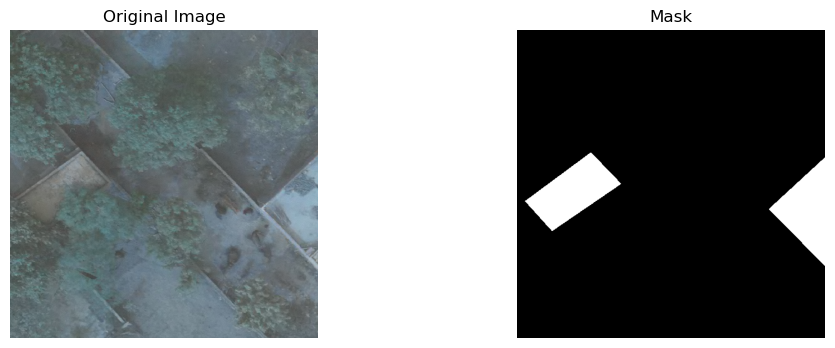

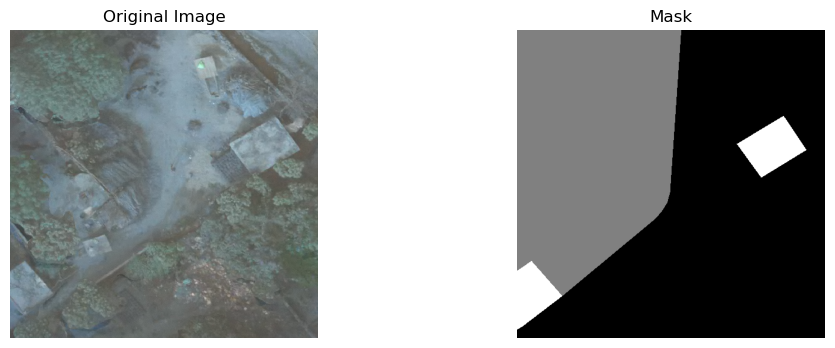

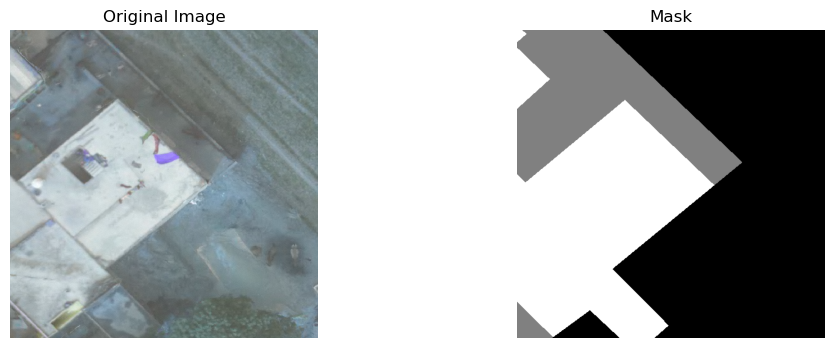

In [5]:
# Set your paths
image_patches_dir = "/home/user/rooftop_detection/village_data/combined_patches/img"
mask_patches_dir = "/home/user/rooftop_detection/village_data/combined_patches/lbl"

# Prepare the dataset
(X_train, y_train), (X_test, y_test) = prepare_dataset(
    image_patches_dir, 
    mask_patches_dir
)

# Visualize some samples to verify
visualize_samples(X_train, y_train)

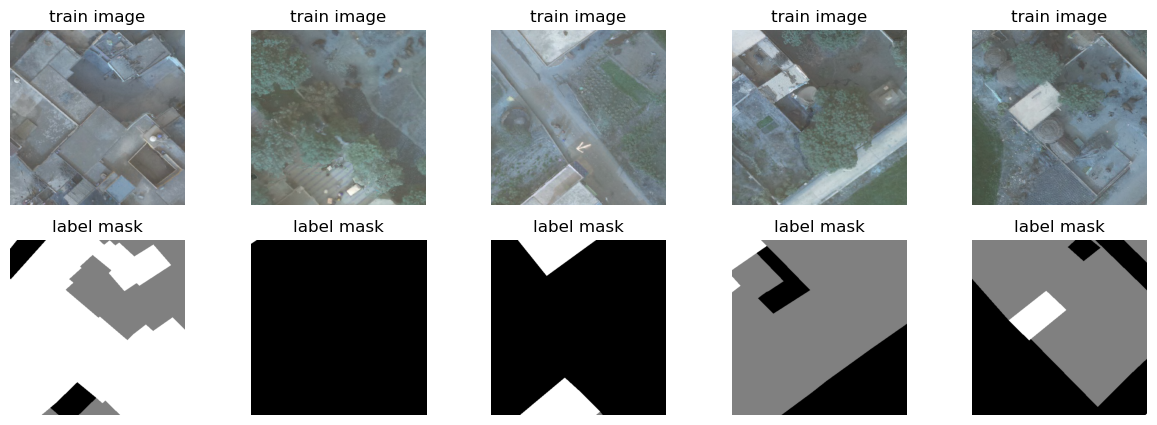

In [6]:
from matplotlib import pyplot as plt

def visualize_samples(images, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(images[idx])
        plt.axis("off")
        plt.title("train image")
        plt. subplot(2, num_samples, num_samples+i+1)
        plt.imshow(labels[idx].squeeze(), cmap="gray")
        plt.axis("off")
        plt.title("label mask")
    plt.show()
visualize_samples(X_train, y_train)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

def build_unet(input_shape=(512, 512, 3)):ponding binary masks f
    """
    Build U-Net model for 3-class segmentation
    """
    inputs = layers.Input(input_shape)
    
    # Encoder
    conv1 = layers.Conv2D(8, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(8, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(16, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bridge
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    
    # Decoder
    up5 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(drop4)
    concat5 = layers.Concatenate()([conv3, up5])
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv5)
    
    up6 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv5)
    concat6 = layers.Concatenate()([conv2, up6])
    conv6 = layers.Conv2D(16, 3, activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(16, 3, activation='relu', padding='same')(conv6)
    
    up7 = layers.Conv2DTranspose(8, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([conv1, up7])
    conv7 = layers.Conv2D(8, 3, activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(8, 3, activation='relu', padding='same')(conv7)
    
    # Output layer with 3 classes
    outputs = layers.Conv2D(3, 1, activation='softmax')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def prepare_for_training(X_train, y_train, X_test, y_test):
    """
    Prepare data for training
    """
    # Convert masks to categorical (one-hot encoding)
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)
    
    return X_train, y_train_cat, X_test, y_test_cat

def train_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=8):
    """
    Train the U-Net model
    """
    # Build model
    model = build_unet()
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=3)]
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]
    
    # Train model
    history = model.fit(ponding binary masks f
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_test, y_test),
        callbacks=callbacks
    )
    
    return model, history

# Function to visualize predictions
def visualize_predictions(model, X_test, y_test, num_samples=3):
    """
    Visualize model predictions
    """
    import matplotlib.pyplot as plt
    
    predictions = model.predict(X_test[:num_samples])
    predictions = np.argmax(predictions, axis=-1)
    
    for i in range(num_samples):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(X_test[i])
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(y_test[i], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        plt.show()

In [11]:
# Prepare data for training
X_train, y_train_cat, X_test, y_test_cat = prepare_for_training(X_train, y_train, X_test, y_test)



2025-02-15 14:38:34.981477: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 555ms/step - accuracy: 0.3321 - loss: 1.0987 - mean_io_u: 0.3333 - val_accuracy: 0.3594 - val_loss: 1.0984 - val_mean_io_u: 0.3333 - learning_rate: 1.0000e-04
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 559ms/step - accuracy: 0.3720 - loss: 1.0975 - mean_io_u: 0.3333 - val_accuracy: 0.4195 - val_loss: 1.0969 - val_mean_io_u: 0.3333 - learning_rate: 1.0000e-04
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 548ms/step - accuracy: 0.4661 - loss: 1.0943 - mean_io_u: 0.3333 - val_accuracy: 0.5195 - val_loss: 1.0850 - val_mean_io_u: 0.3333 - learning_rate: 1.0000e-04
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 550ms/step - accuracy: 0.5521 - loss: 1.0625 - mean_io_u: 0.3333 - val_accuracy: 0.5402 - val_loss: 0.9940 - val_mean_io_u: 0.3333 - learning_rate: 1.0000e-04
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 552ms/step - accuracy: 0.5491 - loss: 0.9814 - mean_io_u: 0.3333 - val_accuracy: 0.5425 - val_loss: 0.9683 - val_mean_io_u: 0.3333 - learning_rate: 1.0000

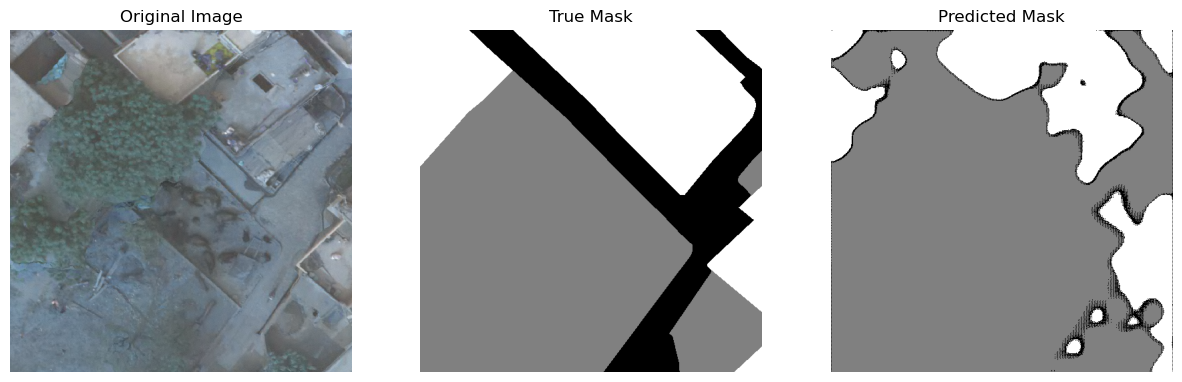

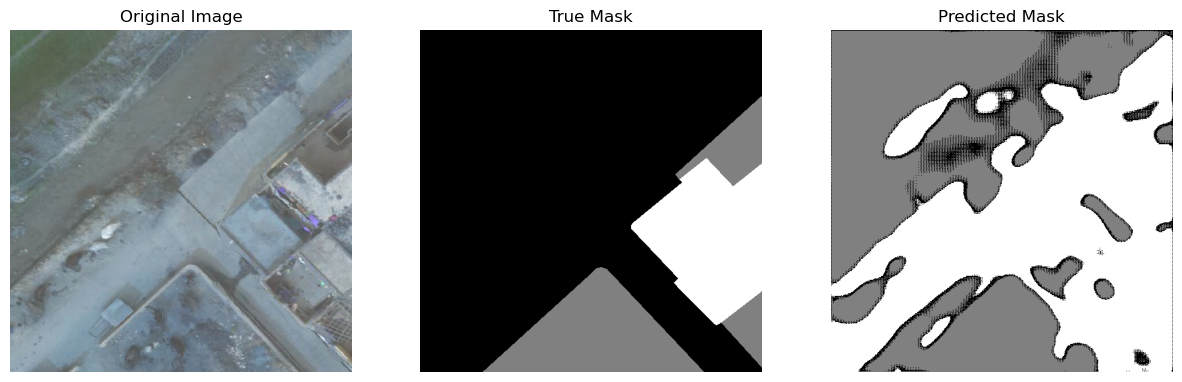

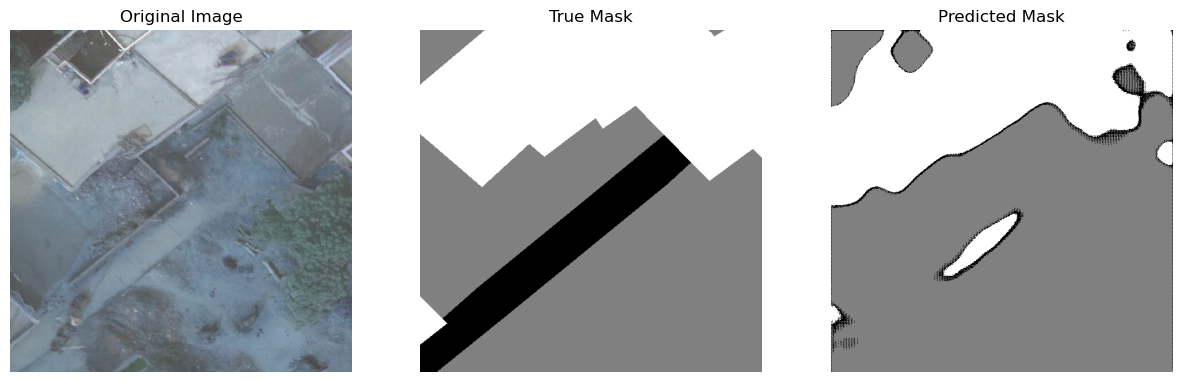

In [12]:
# Train model
model, history = train_model(X_train, y_train_cat, X_test, y_test_cat, epochs=20)

# Visualize some predictions
visualize_predictions(model, X_test, y_test)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_unet_model(input_shape=(512, 512, 3), n_classes=3):
    """
    Create U-Net model for multi-class segmentation
    """
    # Input
    inputs = layers.Input(input_shape)
    
    # Encoder (Contracting Path)
    # Block 1
    conv1 = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    conv1 = layers.Conv2D(16, 3, padding='same', activation='relu')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(32, 3, padding='same', activation='relu')(pool1)
    conv2 = layers.Conv2D(32, 3, padding='same', activation='relu')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Block 3
    conv3 = layers.Conv2D(64, 3, padding='same', activation='relu')(pool2)
    conv3 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Block 4
    conv4 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool3)
    conv4 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bridge
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool4)
    conv5 = layers.Conv2D(256, 3, padding='same', activation='relu')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)
    
    # Decoder (Expansive Path)
    # Block 6
    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(drop5)
    concat6 = layers.Concatenate()([drop4, up6])
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(concat6)
    conv6 = layers.Conv2D(128, 3, padding='same', activation='relu')(conv6)
    
    # Block 7
    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    concat7 = layers.Concatenate()([conv3, up7])
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(concat7)
    conv7 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv7)
    
    # Block 8
    up8 = layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv7)
    concat8 = layers.Concatenate()([conv2, up8])
    conv8 = layers.Conv2D(32, 3, padding='same', activation='relu')(concat8)
    conv8 = layers.Conv2D(32, 3, padding='same', activation='relu')(conv8)
    
    # Block 9
    up9 = layers.Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(conv8)
    concat9 = layers.Concatenate()([conv1, up9])
    conv9 = layers.Conv2D(16, 3, padding='same', activation='relu')(concat9)
    conv9 = layers.Conv2D(16, 3, padding='same', activation='relu')(conv9)
    
    # Output
    outputs = layers.Conv2D(n_classes, 1, activation='softmax')(conv9)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create and compile the model
def prepare_model():
    """
    Create and compile the U-Net model
    """
    model = create_unet_model()
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=3)]
    )
    
    return model

# Create model and print summary
model = prepare_model()
model.summary()

2025-02-15 12:51:09.644061: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_8[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_9[0][0]  

 Total params: 1,941,139 (7.40 MB)

 Trainable params: 1,941,139 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3482 - loss: 1.0997 - mean_io_u: 0.3333

57/57 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3485 - loss: 1.0998 - mean_io_u: 0.3333 - val_accuracy: 0.3891 - val_loss: 1.0897 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4664 - loss: 1.0688 - mean_io_u: 0.3333

57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4667 - loss: 1.0682 - mean_io_u: 0.3333 - val_accuracy: 0.5281 - val_loss: 0.9995 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5552 - loss: 0.9306 - mean_io_u: 0.3333

57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5549 - loss: 0.9307 - mean_io_u: 0.3333 - val_accuracy: 0.5794 - val_loss: 0.8999 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5620 - loss: 0.8987 - mean_io_u: 0.3333 - val_accuracy: 0.5711 - val_loss: 0.9090 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5636 - loss: 0.9040 - mean_io_u: 0.3333

57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5636 - loss: 0.9038 - mean_io_u: 0.3333 - val_accuracy: 0.5921 - val_loss: 0.8755 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.5700 - loss: 0.8886 - mean_io_u: 0.3333 - val_accuracy: 0.5879 - val_loss: 0.8814 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5813 - loss: 0.8802 - mean_io_u: 0.3333 - val_accuracy: 0.5536 - val_loss: 0.9419 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4815 - loss: 1.1966 - mean_io_u: 0.3333 - val_accuracy: 0.4844 - val_loss: 0.9491 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.4932 - loss: 0.9502 - mean_io_u: 0.3333 - val_accuracy: 0.5791 - val_loss: 0.8977 - val_mean_io_u: 0.3333 - learning_rate: 0.0010
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89

57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5962 - loss: 0.8731 - mean_io_u: 0.3333 - val_accuracy: 0.5937 - val_loss: 0.8724 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 15/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.5733 - loss: 0.8789 - mean_io_u: 0.3333 - val_accuracy: 0.5958 - val_loss: 0.8755 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 16/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5823 - loss: 0.8815 - mean_io_u: 0.3333 - val_accuracy: 0.5590 - val_loss: 0.9218 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 17/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5919 - loss: 0.8731 - mean_io_u: 0.3333

57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5918 - loss: 0.8730 - mean_io_u: 0.3333 - val_accuracy: 0.6185 - val_loss: 0.8566 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 18/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.5973 - loss: 0.8659 - mean_io_u: 0.3333 - val_accuracy: 0.5640 - val_loss: 0.8857 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 19/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6075 - loss: 0.8559 - mean_io_u: 0.3333 - val_accuracy: 0.5907 - val_loss: 0.8646 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04
Epoch 20/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.6134 - loss: 0.8468 - mean_io_u: 0.3333 - val_accuracy: 0.5963 - val_loss: 0.8584 - val_mean_io_u: 0.3333 - learning_rate: 5.0000e-04


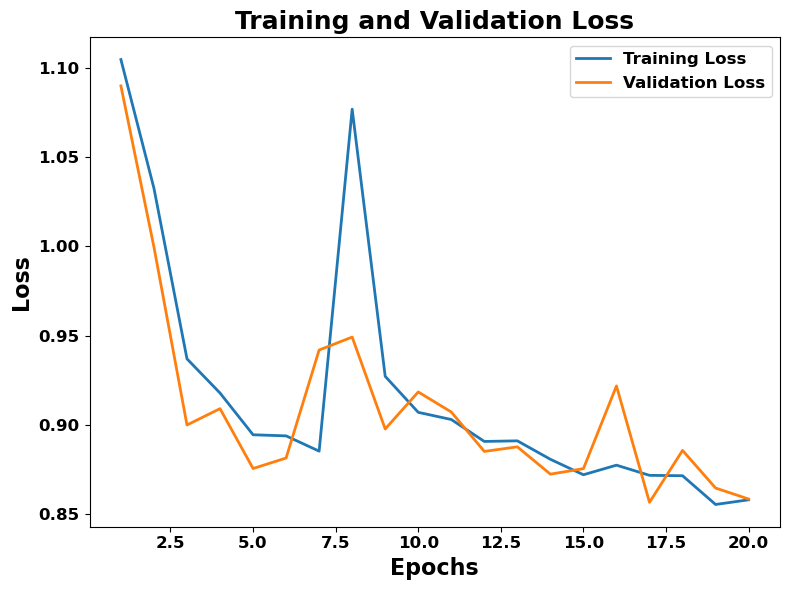

In [18]:
from matplotlib import pyplot as plt
''' graph of val_loss and train_loss ''' 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, '-', label="Training Loss", linewidth=2)
plt.plot(epochs, val_loss, '-', label="Validation Loss", linewidth=2)
plt.title("Training and Validation Loss", fontweight = "bold", fontsize = 18)
plt.xlabel('Epochs', fontweight = 'bold', fontsize = 16)
plt.ylabel('Loss', fontweight = 'bold', fontsize = 16)
plt.legend(loc = 'upper right', prop={'weight':'bold', 'size':12})
plt.xticks(fontsize = 12, fontweight='bold')
plt.yticks(fontsize = 12, fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
######TESTING##########
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6106 - loss: 0.8544 - mean_io_u: 0.3333


ValueError: too many values to unpack (expected 2)

In [28]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [30]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [32]:
def compute_confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

y_test_flat = y_test.flatten()
y_pred_binary_flat = y_pred_binary.flatten()
TP, TN, FP, FN = compute_confusion_matrix(y_test_flat, y_pred_binary_flat)

print(f"True positive:  {TP}")
print(f"True negetive:  {TN}")
print(f"False Positive: {FP}")
print(f"Fasle Negetive: {FN}")

True positive:  14991105
True negetive:  61481341
False Positive: 6676099
Fasle Negetive: 19087615


In [34]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy: .4f}")
prec = TP / (TP+FP)
print(f"Precision: {prec:.4f}")
recall = TP / (TP + FN)
print(f"Recall:   {recall: .4f}")
f1 = 2 * (prec * recall) / (prec + recall)
print(f"F1-Score:  {f1:.4f}")
iou = TP / (TP+FP+FN)
print(f"IoU: {iou: .4f}")

Accuracy:  0.7480
Precision: 0.6919
Recall:    0.4399
F1-Score:  0.5378
IoU:  0.3678


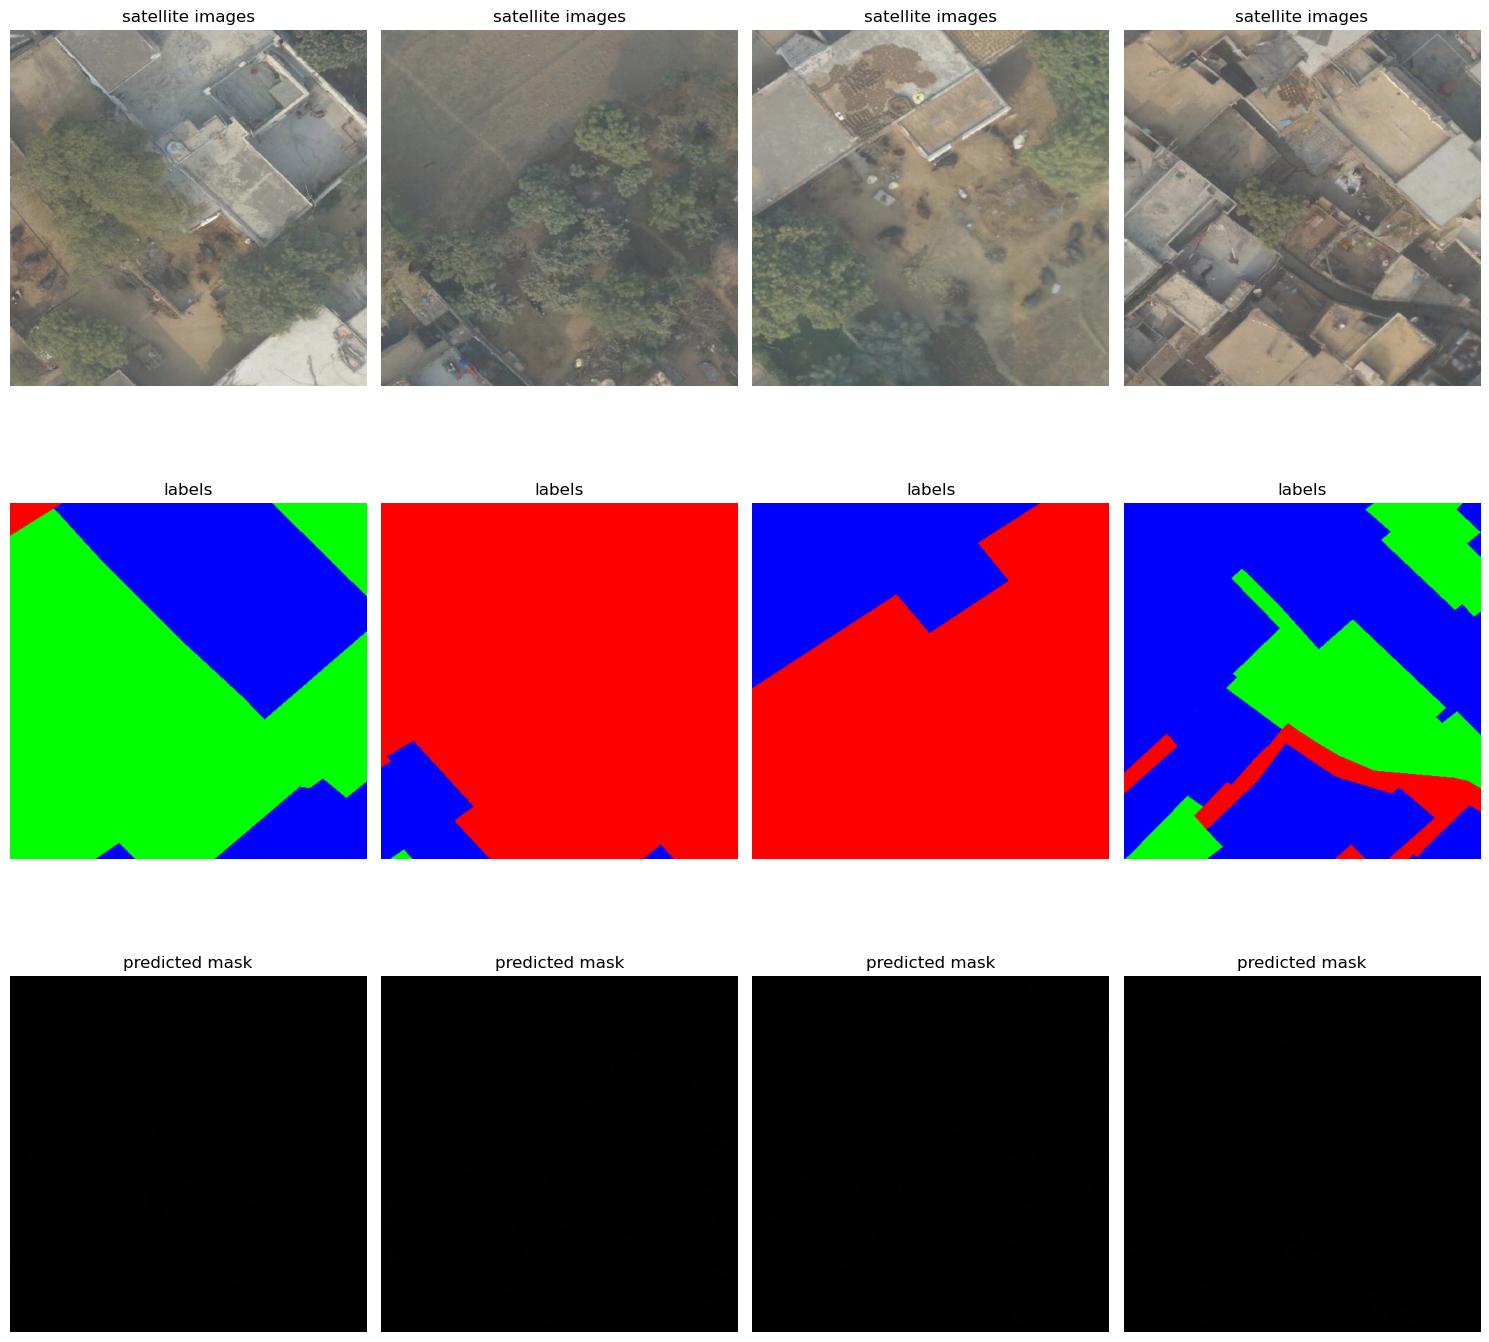

In [42]:
def plot_sample_predictions(X_test, y_test, y_pred_binary, num=4):
    plt.figure(figsize=(15,15))
    for i in range(num):
        idx = np.random.randint(0, len(X_test))
        
        plt.subplot(3, num, i+1)
        plt.imshow(X_test[idx])
        plt.title("satellite images")
        plt.axis("off")
        plt.subplot(3, num, num+1+i)
        plt.imshow(y_test[idx].squeeze(), cmap="gray")
        plt.title("labels")
        plt.axis("off")
        plt.subplot(3, num, 2*num+i+1)
        plt.imshow(y_pred_binary[idx].squeeze(), cmap="gray")
        plt.title("predicted mask")
        plt.axis("off")
        plt.savefig('/home/user/Desktop/rooftop_detection/combinedMASK.png',dpi=500, bbox_inches='tight')
    
    plt.tight_layout()
    plt.show()
    
plot_sample_predictions(X_test, y_test,y_pred_binary)
# plt.savefig('/home/user/Desktop/rooftop_detection/1.png',dpi=300, bbox_inches='tight')

# 2

In [7]:
/home/user/Rooftop dataset/with-overlap

In [9]:
process_satellite_data(
    image_path='/home/user/Rooftop dataset/Marhara.tif',
    shapefile_path='/home/user/Rooftop dataset/Annotations_Marhara_shp/RCC.shp',
    output_dir='/home/user/Rooftop dataset/512_patches',
    tile_size=512,
    overlap=0.5
)

Processing 86x90 patches...

Finished! Generated 0 base patches (not counting augmentations)


False